In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical, multi_gpu_model, Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
data_dir = 'data/'

In [5]:
# train_data = np.load(path.join(data_dir, 'imagenet_6_class_172_train_data.npz'))
# val_data = np.load(path.join(data_dir, 'imagenet_6_class_172_val_data.npz'))

x_train = np.load(path.join(data_dir, 'imagenet_6_class_172_x_train.npy'))
y_train = np.load(path.join(data_dir, 'imagenet_6_class_172_y_train.npy'))
x_val = np.load(path.join(data_dir, 'imagenet_6_class_172_x_val.npy'))
y_val = np.load(path.join(data_dir, 'imagenet_6_class_172_y_val.npy'))
y_list = np.load(path.join(data_dir, 'imagenet_6_class_172_y_list.npy'))

In [6]:
# x_train = train_data['x_data']
# y_train = train_data['y_data']
# x_val = val_data['x_data']
# y_val = val_data['y_data']
x_test = x_val
y_test = y_val
# y_list = val_data['y_list']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_list.shape

((235111, 172, 172, 3),
 (235111,),
 (3183, 172, 172, 3),
 (3183,),
 (3183, 172, 172, 3),
 (3183,),
 (6,))

In [7]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = y_val

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((235111, 172, 172, 3),
 (235111, 6),
 (3183, 172, 172, 3),
 (3183, 6),
 (3183, 172, 172, 3),
 (3183, 6))

In [8]:
input_shape = x_train[0].shape
output_size = len(y_list)

In [9]:
def build_2d_cnn_custom_ch_32_DO(conv_num=1):
    input_layer = Input(shape=input_shape)
    x = input_layer

    for i in range(conv_num):
        x = Conv2D(kernel_size=5, filters=32*(2**(i//2)), strides=(1,1), padding='same')(x)
#         x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=3, strides=(2,2), padding='same')(x)

    x = Flatten()(x)
  
    x = Dropout(0.75)(x)
    output_layer = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [10]:
for i in range(1, 8):
    model = build_2d_cnn_custom_ch_32_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 172, 172, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 172, 172, 32)      2432      
_________________________________________________________________
activation (Activation)      (None, 172, 172, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 86, 86, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 236672)            0         
_________________________________________________________________
dropout (Dropout)    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 172, 172, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 172, 172, 32)      2432      
_________________________________________________________________
activation_21 (Activation)   (None, 172, 172, 32)      0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 86, 86, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 86, 86, 32)        25632     
_________________________________________________________________
activation_22 (Activation)   (None, 86, 86, 32)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 43, 43, 32)        0         
__________

In [35]:
class BalanceDataGenerator(Sequence):
    def __init__(self, x_data, y_data, batch_size, shuffle=True):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.sample_size = int(np.sum(y_data, axis=0).min())
        self.data_shape = x_data.shape[1:]
        self.y_label = self.y_data.argmax(axis=1)
        self.labels = np.unique(self.y_label)
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.y_labels) * self.sample_size / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.zeros((len(self.labels), self.sample_size))
        for i, label in enumerate(self.labels):
            y_index = np.argwhere(self.y_label==label).squeeze()
            if self.shuffle == True:
                self.indexes[i] = np.random.choice(y_index, 
                                   self.sample_size, 
                                   replace=False)
            else:
                self.indexes[i] = y_index[:self.sample_size]
                
        self.indexes = self.indexes.flatten().astype(np.int32)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
                
    def __getitem__(self, batch_idx):
        indices = self.indexes[batch_idx*self.batch_size: (batch_idx+1)*self.batch_size]
        return self.x_data[indices], self.y_data[indices]    

In [40]:
batch_size = 40
data_generator = BalanceDataGenerator(x_train, y_train,
                                      batch_size=batch_size)

array([4., 7., 8., 4., 9., 8.], dtype=float32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10000
3200/3183 [==============================] - 25s 8ms/sample - loss: 0.4682 - acc: 0.8913

Epoch 00001: val_loss improved from inf to 0.46823, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_3_conv_checkpoint/001-0.4682.hdf5
81/81 [==============================] - 34s 414ms/step - loss: 0.7268 - acc: 0.5764 - val_loss: 0.4682 - val_acc: 0.8913
Epoch 2/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.6818 - acc: 0.5778

Epoch 00002: val_loss did not improve from 0.46823
81/81 [==============================] - 20s 248ms/step - loss: 0.5094 - acc: 0.7480 - val_loss: 0.6818 - val_acc: 0.5778
Epoch 3/10000
3200/3183 [==============================] - 14s 4ms/sample - loss: 0.4072 - acc: 0.8003

Epoch 00003: val_loss improved from 0.46823 to 0.40719, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_3_conv_ch

3200/3183 [==============================] - 19s 6ms/sample - loss: 0.1888 - acc: 0.9406

Epoch 00014: val_loss did not improve from 0.10923
81/81 [==============================] - 23s 286ms/step - loss: 0.2135 - acc: 0.9174 - val_loss: 0.1888 - val_acc: 0.9406
Epoch 15/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.3119 - acc: 0.8669

Epoch 00015: val_loss did not improve from 0.10923
81/81 [==============================] - 22s 265ms/step - loss: 0.2046 - acc: 0.9240 - val_loss: 0.3119 - val_acc: 0.8669
Epoch 16/10000
3200/3183 [==============================] - 24s 8ms/sample - loss: 0.1830 - acc: 0.9450

Epoch 00016: val_loss did not improve from 0.10923
81/81 [==============================] - 28s 345ms/step - loss: 0.1742 - acc: 0.9376 - val_loss: 0.1830 - val_acc: 0.9450
Epoch 17/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.1782 - acc: 0.9422

Epoch 00017: val_loss did not improve from 0.10923
81/81 [==================

3200/3183 [==============================] - 17s 5ms/sample - loss: 0.1498 - acc: 0.9500

Epoch 00029: val_loss did not improve from 0.06312
81/81 [==============================] - 20s 248ms/step - loss: 0.1725 - acc: 0.9401 - val_loss: 0.1498 - val_acc: 0.9500
Epoch 30/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.1056 - acc: 0.9616

Epoch 00030: val_loss did not improve from 0.06312
81/81 [==============================] - 21s 263ms/step - loss: 0.1396 - acc: 0.9513 - val_loss: 0.1056 - val_acc: 0.9616
Epoch 31/10000
3190/3183 [==============================] - 22s 7ms/sample - loss: 0.0528 - acc: 0.9774

Epoch 00031: val_loss improved from 0.06312 to 0.05278, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_3_conv_checkpoint/031-0.0528.hdf5
81/81 [==============================] - 26s 321ms/step - loss: 0.1439 - acc: 0.9500 - val_loss: 0.0528 - val_acc: 0.9774
Epoch 32/10000
3200/3183 [===================

3200/3183 [==============================] - 22s 7ms/sample - loss: 0.1111 - acc: 0.9638

Epoch 00044: val_loss did not improve from 0.05042
81/81 [==============================] - 27s 328ms/step - loss: 0.1458 - acc: 0.9482 - val_loss: 0.1111 - val_acc: 0.9638
Epoch 45/10000
3200/3183 [==============================] - 23s 7ms/sample - loss: 0.0585 - acc: 0.9800

Epoch 00045: val_loss did not improve from 0.05042
81/81 [==============================] - 28s 348ms/step - loss: 0.1166 - acc: 0.9584 - val_loss: 0.0585 - val_acc: 0.9800
Epoch 46/10000
3200/3183 [==============================] - 21s 7ms/sample - loss: 0.1101 - acc: 0.9597

Epoch 00046: val_loss did not improve from 0.05042
81/81 [==============================] - 28s 351ms/step - loss: 0.1024 - acc: 0.9615 - val_loss: 0.1101 - val_acc: 0.9597
Epoch 47/10000
3200/3183 [==============================] - 15s 5ms/sample - loss: 0.0756 - acc: 0.9750

Epoch 00047: val_loss did not improve from 0.05042
81/81 [==================

Epoch 60/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.1681 - acc: 0.9325

Epoch 00060: val_loss did not improve from 0.04939
81/81 [==============================] - 21s 264ms/step - loss: 0.1086 - acc: 0.9606 - val_loss: 0.1681 - val_acc: 0.9325
Epoch 61/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0668 - acc: 0.9725

Epoch 00061: val_loss did not improve from 0.04939
81/81 [==============================] - 24s 294ms/step - loss: 0.1023 - acc: 0.9668 - val_loss: 0.0668 - val_acc: 0.9725
Epoch 62/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0760 - acc: 0.9725

Epoch 00062: val_loss did not improve from 0.04939
81/81 [==============================] - 24s 294ms/step - loss: 0.0908 - acc: 0.9696 - val_loss: 0.0760 - val_acc: 0.9725
Epoch 63/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0915 - acc: 0.9650

Epoch 00063: val_loss did not improve from 0.04939
81/81 [===

3200/3183 [==============================] - 16s 5ms/sample - loss: 0.1055 - acc: 0.9600

Epoch 00075: val_loss did not improve from 0.04832
81/81 [==============================] - 20s 250ms/step - loss: 0.0817 - acc: 0.9705 - val_loss: 0.1055 - val_acc: 0.9600
Epoch 76/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.1236 - acc: 0.9513

Epoch 00076: val_loss did not improve from 0.04832
81/81 [==============================] - 23s 282ms/step - loss: 0.0826 - acc: 0.9727 - val_loss: 0.1236 - val_acc: 0.9513
Epoch 77/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0776 - acc: 0.9725

Epoch 00077: val_loss did not improve from 0.04832
81/81 [==============================] - 22s 270ms/step - loss: 0.0874 - acc: 0.9721 - val_loss: 0.0776 - val_acc: 0.9725
Epoch 78/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0444 - acc: 0.9850

Epoch 00078: val_loss improved from 0.04832 to 0.04436, saving model to mode

Epoch 91/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0586 - acc: 0.9762

Epoch 00091: val_loss did not improve from 0.04436
81/81 [==============================] - 24s 296ms/step - loss: 0.0748 - acc: 0.9758 - val_loss: 0.0586 - val_acc: 0.9762
Epoch 92/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0557 - acc: 0.9741

Epoch 00092: val_loss did not improve from 0.04436
81/81 [==============================] - 21s 260ms/step - loss: 0.0803 - acc: 0.9755 - val_loss: 0.0557 - val_acc: 0.9741
Epoch 93/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0421 - acc: 0.9875

Epoch 00093: val_loss improved from 0.04436 to 0.04206, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_3_conv_checkpoint/093-0.0421.hdf5
81/81 [==============================] - 23s 278ms/step - loss: 0.0835 - acc: 0.9724 - val_loss: 0.0421 - val_acc: 0.9875
Epoch 94/10000
3200/3183 [====

3200/3183 [==============================] - 24s 8ms/sample - loss: 0.0856 - acc: 0.9712

Epoch 00106: val_loss did not improve from 0.04206
81/81 [==============================] - 29s 353ms/step - loss: 0.0664 - acc: 0.9801 - val_loss: 0.0856 - val_acc: 0.9712
Epoch 107/10000
3200/3183 [==============================] - 22s 7ms/sample - loss: 0.0650 - acc: 0.9744

Epoch 00107: val_loss did not improve from 0.04206
81/81 [==============================] - 26s 323ms/step - loss: 0.0661 - acc: 0.9770 - val_loss: 0.0650 - val_acc: 0.9744
Epoch 108/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0426 - acc: 0.9844

Epoch 00108: val_loss did not improve from 0.04206
81/81 [==============================] - 22s 272ms/step - loss: 0.0616 - acc: 0.9780 - val_loss: 0.0426 - val_acc: 0.9844
Epoch 109/10000
3200/3183 [==============================] - 24s 8ms/sample - loss: 0.0763 - acc: 0.9725

Epoch 00109: val_loss did not improve from 0.04206
81/81 [===============

Epoch 122/10000
3200/3183 [==============================] - 23s 7ms/sample - loss: 0.0840 - acc: 0.9650

Epoch 00122: val_loss did not improve from 0.03476
81/81 [==============================] - 27s 329ms/step - loss: 0.0659 - acc: 0.9820 - val_loss: 0.0840 - val_acc: 0.9650
Epoch 123/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0500 - acc: 0.9875

Epoch 00123: val_loss did not improve from 0.03476
81/81 [==============================] - 22s 273ms/step - loss: 0.0691 - acc: 0.9742 - val_loss: 0.0500 - val_acc: 0.9875
Epoch 124/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0361 - acc: 0.9850

Epoch 00124: val_loss did not improve from 0.03476
81/81 [==============================] - 23s 285ms/step - loss: 0.0536 - acc: 0.9832 - val_loss: 0.0361 - val_acc: 0.9850
Epoch 125/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0519 - acc: 0.9825

Epoch 00125: val_loss did not improve from 0.03476
81/81 

3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0546 - acc: 0.9812

Epoch 00137: val_loss did not improve from 0.03410
81/81 [==============================] - 24s 291ms/step - loss: 0.0406 - acc: 0.9848 - val_loss: 0.0546 - val_acc: 0.9812
Epoch 138/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0578 - acc: 0.98067s - loss: 0.068

Epoch 00138: val_loss did not improve from 0.03410
81/81 [==============================] - 21s 261ms/step - loss: 0.0406 - acc: 0.9885 - val_loss: 0.0578 - val_acc: 0.9806
Epoch 139/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0700 - acc: 0.9725

Epoch 00139: val_loss did not improve from 0.03410
81/81 [==============================] - 23s 283ms/step - loss: 0.0470 - acc: 0.9839 - val_loss: 0.0700 - val_acc: 0.9725
Epoch 140/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0888 - acc: 0.9703

Epoch 00140: val_loss did not improve from 0.03410
81/81 

3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0386 - acc: 0.9900

Epoch 00153: val_loss did not improve from 0.03410
81/81 [==============================] - 23s 281ms/step - loss: 0.0397 - acc: 0.9894 - val_loss: 0.0386 - val_acc: 0.9900
Epoch 154/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0720 - acc: 0.9700

Epoch 00154: val_loss did not improve from 0.03410
81/81 [==============================] - 21s 256ms/step - loss: 0.0522 - acc: 0.9804 - val_loss: 0.0720 - val_acc: 0.9700
Epoch 155/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0455 - acc: 0.9837

Epoch 00155: val_loss did not improve from 0.03410
81/81 [==============================] - 21s 256ms/step - loss: 0.0425 - acc: 0.9854 - val_loss: 0.0455 - val_acc: 0.9837
Epoch 156/10000
3200/3183 [==============================] - 27s 8ms/sample - loss: 0.0462 - acc: 0.9850

Epoch 00156: val_loss did not improve from 0.03410
81/81 [===============

3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0579 - acc: 0.9775

Epoch 00168: val_loss did not improve from 0.03410
81/81 [==============================] - 21s 255ms/step - loss: 0.0428 - acc: 0.9863 - val_loss: 0.0579 - val_acc: 0.9775
Epoch 169/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0407 - acc: 0.9850

Epoch 00169: val_loss did not improve from 0.03410
81/81 [==============================] - 21s 263ms/step - loss: 0.0324 - acc: 0.9898 - val_loss: 0.0407 - val_acc: 0.9850
Epoch 170/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0302 - acc: 0.9937

Epoch 00170: val_loss improved from 0.03410 to 0.03023, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_3_conv_checkpoint/170-0.0302.hdf5
81/81 [==============================] - 25s 305ms/step - loss: 0.0464 - acc: 0.9857 - val_loss: 0.0302 - val_acc: 0.9937
Epoch 171/10000
3200/3183 [================

Epoch 184/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0245 - acc: 0.9900

Epoch 00184: val_loss improved from 0.03023 to 0.02453, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_3_conv_checkpoint/184-0.0245.hdf5
81/81 [==============================] - 22s 271ms/step - loss: 0.0411 - acc: 0.9854 - val_loss: 0.0245 - val_acc: 0.9900
Epoch 185/10000
3200/3183 [==============================] - 21s 6ms/sample - loss: 0.0370 - acc: 0.9866

Epoch 00185: val_loss did not improve from 0.02453
81/81 [==============================] - 24s 297ms/step - loss: 0.0375 - acc: 0.9882 - val_loss: 0.0370 - val_acc: 0.9866
Epoch 186/10000
3200/3183 [==============================] - 18s 5ms/sample - loss: 0.0610 - acc: 0.9750

Epoch 00186: val_loss did not improve from 0.02453
81/81 [==============================] - 22s 274ms/step - loss: 0.0310 - acc: 0.9901 - val_loss: 0.0610 - val_acc: 0.9750
Epoch 187/10000
3200/3183 [

3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0409 - acc: 0.9837

Epoch 00199: val_loss did not improve from 0.02453
81/81 [==============================] - 23s 281ms/step - loss: 0.0314 - acc: 0.9901 - val_loss: 0.0409 - val_acc: 0.9837
Epoch 200/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0675 - acc: 0.97502s - loss: 0.0652 - acc: 

Epoch 00200: val_loss did not improve from 0.02453
81/81 [==============================] - 23s 289ms/step - loss: 0.0322 - acc: 0.9932 - val_loss: 0.0675 - val_acc: 0.9750
Epoch 201/10000
3200/3183 [==============================] - 22s 7ms/sample - loss: 0.0564 - acc: 0.9766

Epoch 00201: val_loss did not improve from 0.02453
81/81 [==============================] - 29s 358ms/step - loss: 0.0393 - acc: 0.9885 - val_loss: 0.0564 - val_acc: 0.9766
Epoch 202/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0308 - acc: 0.9850

Epoch 00202: val_loss did not improve from 0.024

Epoch 215/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0435 - acc: 0.9894

Epoch 00215: val_loss did not improve from 0.02453
81/81 [==============================] - 25s 308ms/step - loss: 0.0431 - acc: 0.9848 - val_loss: 0.0435 - val_acc: 0.9894
Epoch 216/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0567 - acc: 0.9737

Epoch 00216: val_loss did not improve from 0.02453
81/81 [==============================] - 23s 282ms/step - loss: 0.0286 - acc: 0.9929 - val_loss: 0.0567 - val_acc: 0.9737
Epoch 217/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0592 - acc: 0.9775

Epoch 00217: val_loss did not improve from 0.02453
81/81 [==============================] - 23s 290ms/step - loss: 0.0294 - acc: 0.9910 - val_loss: 0.0592 - val_acc: 0.9775
Epoch 218/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0374 - acc: 0.9900

Epoch 00218: val_loss did not improve from 0.02453
81/81 

3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0312 - acc: 0.9925

Epoch 00230: val_loss did not improve from 0.02453
81/81 [==============================] - 21s 260ms/step - loss: 0.0264 - acc: 0.9919 - val_loss: 0.0312 - val_acc: 0.9925
Epoch 231/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0283 - acc: 0.9900

Epoch 00231: val_loss did not improve from 0.02453
81/81 [==============================] - 23s 283ms/step - loss: 0.0353 - acc: 0.9891 - val_loss: 0.0283 - val_acc: 0.9900
Epoch 232/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0431 - acc: 0.9850

Epoch 00232: val_loss did not improve from 0.02453
81/81 [==============================] - 23s 283ms/step - loss: 0.0315 - acc: 0.9870 - val_loss: 0.0431 - val_acc: 0.9850
Epoch 233/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0376 - acc: 0.9850

Epoch 00233: val_loss did not improve from 0.02453
81/81 [===============

3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0347 - acc: 0.9925

Epoch 00246: val_loss did not improve from 0.02453
81/81 [==============================] - 23s 281ms/step - loss: 0.0247 - acc: 0.9922 - val_loss: 0.0347 - val_acc: 0.9925
Epoch 247/10000
3200/3183 [==============================] - 18s 5ms/sample - loss: 0.0569 - acc: 0.9737

Epoch 00247: val_loss did not improve from 0.02453
81/81 [==============================] - 21s 264ms/step - loss: 0.0268 - acc: 0.9910 - val_loss: 0.0569 - val_acc: 0.9737
Epoch 248/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0298 - acc: 0.9875

Epoch 00248: val_loss did not improve from 0.02453
81/81 [==============================] - 21s 261ms/step - loss: 0.0334 - acc: 0.9904 - val_loss: 0.0298 - val_acc: 0.9875
Epoch 249/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0302 - acc: 0.9900

Epoch 00249: val_loss did not improve from 0.02453
81/81 [===============

3200/3183 [==============================] - 23s 7ms/sample - loss: 0.0433 - acc: 0.9875

Epoch 00261: val_loss did not improve from 0.02453
81/81 [==============================] - 26s 324ms/step - loss: 0.0348 - acc: 0.9910 - val_loss: 0.0433 - val_acc: 0.9875
Epoch 262/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0493 - acc: 0.9841

Epoch 00262: val_loss did not improve from 0.02453
81/81 [==============================] - 25s 314ms/step - loss: 0.0301 - acc: 0.9898 - val_loss: 0.0493 - val_acc: 0.9841
Epoch 263/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0455 - acc: 0.9859

Epoch 00263: val_loss did not improve from 0.02453
81/81 [==============================] - 23s 279ms/step - loss: 0.0330 - acc: 0.9901 - val_loss: 0.0455 - val_acc: 0.9859
Epoch 264/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0420 - acc: 0.9850

Epoch 00264: val_loss did not improve from 0.02453
81/81 [===============

3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0308 - acc: 0.9925

Epoch 00277: val_loss did not improve from 0.02453
81/81 [==============================] - 21s 254ms/step - loss: 0.0190 - acc: 0.9938 - val_loss: 0.0308 - val_acc: 0.9925
Epoch 278/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0453 - acc: 0.9875

Epoch 00278: val_loss did not improve from 0.02453
81/81 [==============================] - 22s 277ms/step - loss: 0.0236 - acc: 0.9919 - val_loss: 0.0453 - val_acc: 0.9875
Epoch 279/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0358 - acc: 0.9919

Epoch 00279: val_loss did not improve from 0.02453
81/81 [==============================] - 21s 263ms/step - loss: 0.0319 - acc: 0.9907 - val_loss: 0.0358 - val_acc: 0.9919
Epoch 280/10000
3200/3183 [==============================] - 27s 9ms/sample - loss: 0.0332 - acc: 0.9909

Epoch 00280: val_loss did not improve from 0.02453
81/81 [===============

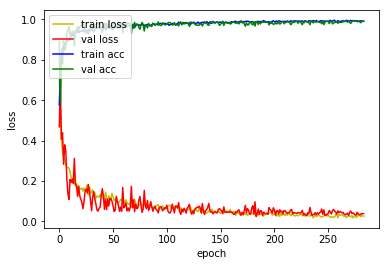

3183/3183 [==============================] - 4s 1ms/sample - loss: 10.6577 - acc: 0.3358
Loss: 10.65774965957938 Accuracy: 0.3358467

Epoch 1/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.6675 - acc: 0.7225

Epoch 00001: val_loss improved from inf to 0.66748, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_4_conv_checkpoint/001-0.6675.hdf5
81/81 [==============================] - 22s 271ms/step - loss: 0.8650 - acc: 0.4947 - val_loss: 0.6675 - val_acc: 0.7225
Epoch 2/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.5309 - acc: 0.7631

Epoch 00002: val_loss improved from 0.66748 to 0.53095, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_4_conv_checkpoint/002-0.5309.hdf5
81/81 [==============================] - 21s 258ms/step - loss: 0.6314 - acc: 0.6449 - val_loss: 0.5309 - val_acc: 0.7631
Epoch 3/10000
3200/3183 [===================

3200/3183 [==============================] - 18s 5ms/sample - loss: 0.1986 - acc: 0.9300

Epoch 00014: val_loss did not improve from 0.13863
81/81 [==============================] - 23s 282ms/step - loss: 0.1929 - acc: 0.9258 - val_loss: 0.1986 - val_acc: 0.9300
Epoch 15/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.2520 - acc: 0.8931

Epoch 00015: val_loss did not improve from 0.13863
81/81 [==============================] - 22s 271ms/step - loss: 0.1856 - acc: 0.9311 - val_loss: 0.2520 - val_acc: 0.8931
Epoch 16/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.2428 - acc: 0.9038

Epoch 00016: val_loss did not improve from 0.13863
81/81 [==============================] - 22s 269ms/step - loss: 0.1910 - acc: 0.9261 - val_loss: 0.2428 - val_acc: 0.9038
Epoch 17/10000
3200/3183 [==============================] - 18s 5ms/sample - loss: 0.0702 - acc: 0.9750

Epoch 00017: val_loss improved from 0.13863 to 0.07018, saving model to mode

3200/3183 [==============================] - 23s 7ms/sample - loss: 0.0653 - acc: 0.9837

Epoch 00029: val_loss did not improve from 0.06430
81/81 [==============================] - 27s 333ms/step - loss: 0.1250 - acc: 0.9547 - val_loss: 0.0653 - val_acc: 0.9837
Epoch 30/10000
3200/3183 [==============================] - 31s 10ms/sample - loss: 0.3289 - acc: 0.8625

Epoch 00030: val_loss did not improve from 0.06430
81/81 [==============================] - 34s 426ms/step - loss: 0.1520 - acc: 0.9423 - val_loss: 0.3289 - val_acc: 0.8625
Epoch 31/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0768 - acc: 0.9725

Epoch 00031: val_loss did not improve from 0.06430
81/81 [==============================] - 26s 327ms/step - loss: 0.1394 - acc: 0.9420 - val_loss: 0.0768 - val_acc: 0.9725
Epoch 32/10000
3200/3183 [==============================] - 21s 7ms/sample - loss: 0.0647 - acc: 0.9787

Epoch 00032: val_loss did not improve from 0.06430
81/81 [=================

3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0609 - acc: 0.9725

Epoch 00045: val_loss improved from 0.06430 to 0.06094, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_4_conv_checkpoint/045-0.0609.hdf5
81/81 [==============================] - 22s 275ms/step - loss: 0.1167 - acc: 0.9603 - val_loss: 0.0609 - val_acc: 0.9725
Epoch 46/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.1629 - acc: 0.9400

Epoch 00046: val_loss did not improve from 0.06094
81/81 [==============================] - 24s 293ms/step - loss: 0.1010 - acc: 0.9677 - val_loss: 0.1629 - val_acc: 0.9400
Epoch 47/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.1036 - acc: 0.9575

Epoch 00047: val_loss did not improve from 0.06094
81/81 [==============================] - 22s 275ms/step - loss: 0.0926 - acc: 0.9668 - val_loss: 0.1036 - val_acc: 0.9575
Epoch 48/10000
3200/3183 [===================

Epoch 60/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0689 - acc: 0.9750

Epoch 00060: val_loss did not improve from 0.04743
81/81 [==============================] - 21s 262ms/step - loss: 0.0911 - acc: 0.9687 - val_loss: 0.0689 - val_acc: 0.9750
Epoch 61/10000
3200/3183 [==============================] - 18s 5ms/sample - loss: 0.0455 - acc: 0.9875

Epoch 00061: val_loss improved from 0.04743 to 0.04554, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_4_conv_checkpoint/061-0.0455.hdf5
81/81 [==============================] - 24s 297ms/step - loss: 0.0976 - acc: 0.9603 - val_loss: 0.0455 - val_acc: 0.9875
Epoch 62/10000
3200/3183 [==============================] - 15s 5ms/sample - loss: 0.0427 - acc: 0.9875

Epoch 00062: val_loss improved from 0.04554 to 0.04266, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_4_conv_checkpoint/062-0.0427.hdf5
81/81 [=========

Epoch 75/10000
3200/3183 [==============================] - 22s 7ms/sample - loss: 0.0762 - acc: 0.9725

Epoch 00075: val_loss did not improve from 0.03937
81/81 [==============================] - 28s 344ms/step - loss: 0.0654 - acc: 0.9770 - val_loss: 0.0762 - val_acc: 0.9725
Epoch 76/10000
3200/3183 [==============================] - 21s 7ms/sample - loss: 0.0508 - acc: 0.9831

Epoch 00076: val_loss did not improve from 0.03937
81/81 [==============================] - 28s 346ms/step - loss: 0.0735 - acc: 0.9749 - val_loss: 0.0508 - val_acc: 0.9831
Epoch 77/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.2039 - acc: 0.9262

Epoch 00077: val_loss did not improve from 0.03937
81/81 [==============================] - 26s 317ms/step - loss: 0.0836 - acc: 0.9687 - val_loss: 0.2039 - val_acc: 0.9262
Epoch 78/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.1483 - acc: 0.9466

Epoch 00078: val_loss did not improve from 0.03937
81/81 [===

3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0837 - acc: 0.9725

Epoch 00090: val_loss did not improve from 0.03937
81/81 [==============================] - 24s 294ms/step - loss: 0.0885 - acc: 0.9690 - val_loss: 0.0837 - val_acc: 0.9725
Epoch 91/10000
3200/3183 [==============================] - 21s 7ms/sample - loss: 0.0967 - acc: 0.9559

Epoch 00091: val_loss did not improve from 0.03937
81/81 [==============================] - 27s 336ms/step - loss: 0.0574 - acc: 0.9811 - val_loss: 0.0967 - val_acc: 0.9559
Epoch 92/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0448 - acc: 0.9850

Epoch 00092: val_loss did not improve from 0.03937
81/81 [==============================] - 25s 309ms/step - loss: 0.0630 - acc: 0.9789 - val_loss: 0.0448 - val_acc: 0.9850
Epoch 93/10000
3200/3183 [==============================] - 15s 5ms/sample - loss: 0.0431 - acc: 0.9856

Epoch 00093: val_loss did not improve from 0.03937
81/81 [==================

Epoch 106/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0548 - acc: 0.9766

Epoch 00106: val_loss did not improve from 0.03563
81/81 [==============================] - 31s 384ms/step - loss: 0.0629 - acc: 0.9792 - val_loss: 0.0548 - val_acc: 0.9766
Epoch 107/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0771 - acc: 0.9709

Epoch 00107: val_loss did not improve from 0.03563
81/81 [==============================] - 22s 271ms/step - loss: 0.0568 - acc: 0.9808 - val_loss: 0.0771 - val_acc: 0.9709
Epoch 108/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0402 - acc: 0.9875

Epoch 00108: val_loss did not improve from 0.03563
81/81 [==============================] - 22s 271ms/step - loss: 0.0532 - acc: 0.9817 - val_loss: 0.0402 - val_acc: 0.9875
Epoch 109/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0538 - acc: 0.9819

Epoch 00109: val_loss did not improve from 0.03563
81/81 

3200/3183 [==============================] - 21s 6ms/sample - loss: 0.0519 - acc: 0.9825

Epoch 00121: val_loss did not improve from 0.03563
81/81 [==============================] - 25s 305ms/step - loss: 0.0447 - acc: 0.9848 - val_loss: 0.0519 - val_acc: 0.9825
Epoch 122/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0472 - acc: 0.9819

Epoch 00122: val_loss did not improve from 0.03563
81/81 [==============================] - 22s 272ms/step - loss: 0.0433 - acc: 0.9857 - val_loss: 0.0472 - val_acc: 0.9819
Epoch 123/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0476 - acc: 0.9872

Epoch 00123: val_loss did not improve from 0.03563
81/81 [==============================] - 25s 305ms/step - loss: 0.0515 - acc: 0.9798 - val_loss: 0.0476 - val_acc: 0.9872
Epoch 124/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0391 - acc: 0.9844

Epoch 00124: val_loss did not improve from 0.03563
81/81 [===============

3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0652 - acc: 0.9784

Epoch 00137: val_loss did not improve from 0.03563
81/81 [==============================] - 24s 295ms/step - loss: 0.0470 - acc: 0.9857 - val_loss: 0.0652 - val_acc: 0.9784
Epoch 138/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0527 - acc: 0.9850

Epoch 00138: val_loss did not improve from 0.03563
81/81 [==============================] - 25s 304ms/step - loss: 0.0464 - acc: 0.9870 - val_loss: 0.0527 - val_acc: 0.9850
Epoch 139/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0443 - acc: 0.9900

Epoch 00139: val_loss did not improve from 0.03563
81/81 [==============================] - 23s 289ms/step - loss: 0.0355 - acc: 0.9898 - val_loss: 0.0443 - val_acc: 0.9900
Epoch 140/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0515 - acc: 0.9800

Epoch 00140: val_loss did not improve from 0.03563
81/81 [===============

3200/3183 [==============================] - 24s 7ms/sample - loss: 0.0624 - acc: 0.9775

Epoch 00152: val_loss did not improve from 0.03563
81/81 [==============================] - 28s 342ms/step - loss: 0.0431 - acc: 0.9860 - val_loss: 0.0624 - val_acc: 0.9775
Epoch 153/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0644 - acc: 0.9719

Epoch 00153: val_loss did not improve from 0.03563
81/81 [==============================] - 25s 310ms/step - loss: 0.0359 - acc: 0.9898 - val_loss: 0.0644 - val_acc: 0.9719
Epoch 154/10000
3200/3183 [==============================] - 21s 7ms/sample - loss: 0.0491 - acc: 0.9878

Epoch 00154: val_loss did not improve from 0.03563
81/81 [==============================] - 26s 319ms/step - loss: 0.0357 - acc: 0.9882 - val_loss: 0.0491 - val_acc: 0.9878
Epoch 155/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0550 - acc: 0.9831

Epoch 00155: val_loss did not improve from 0.03563
81/81 [===============

3200/3183 [==============================] - 21s 6ms/sample - loss: 0.0394 - acc: 0.9878

Epoch 00167: val_loss did not improve from 0.03263
81/81 [==============================] - 25s 306ms/step - loss: 0.0405 - acc: 0.9870 - val_loss: 0.0394 - val_acc: 0.9878
Epoch 168/10000
3200/3183 [==============================] - 27s 9ms/sample - loss: 0.0336 - acc: 0.9919

Epoch 00168: val_loss did not improve from 0.03263
81/81 [==============================] - 34s 418ms/step - loss: 0.0266 - acc: 0.9907 - val_loss: 0.0336 - val_acc: 0.9919
Epoch 169/10000
3200/3183 [==============================] - 25s 8ms/sample - loss: 0.0412 - acc: 0.9875

Epoch 00169: val_loss did not improve from 0.03263
81/81 [==============================] - 33s 410ms/step - loss: 0.0328 - acc: 0.9882 - val_loss: 0.0412 - val_acc: 0.9875
Epoch 170/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0304 - acc: 0.9925

Epoch 00170: val_loss improved from 0.03263 to 0.03040, saving model to m

Epoch 183/10000
3200/3183 [==============================] - 22s 7ms/sample - loss: 0.0419 - acc: 0.9862

Epoch 00183: val_loss did not improve from 0.03040
81/81 [==============================] - 27s 327ms/step - loss: 0.0365 - acc: 0.9888 - val_loss: 0.0419 - val_acc: 0.9862
Epoch 184/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0406 - acc: 0.9869

Epoch 00184: val_loss did not improve from 0.03040
81/81 [==============================] - 23s 284ms/step - loss: 0.0273 - acc: 0.9904 - val_loss: 0.0406 - val_acc: 0.9869
Epoch 185/10000
3200/3183 [==============================] - 14s 5ms/sample - loss: 0.0344 - acc: 0.9872

Epoch 00185: val_loss did not improve from 0.03040
81/81 [==============================] - 20s 250ms/step - loss: 0.0304 - acc: 0.9901 - val_loss: 0.0344 - val_acc: 0.9872
Epoch 186/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0792 - acc: 0.9731

Epoch 00186: val_loss did not improve from 0.03040
81/81 

3200/3183 [==============================] - 23s 7ms/sample - loss: 0.0490 - acc: 0.9819

Epoch 00198: val_loss did not improve from 0.03040
81/81 [==============================] - 27s 335ms/step - loss: 0.0215 - acc: 0.9932 - val_loss: 0.0490 - val_acc: 0.9819
Epoch 199/10000
3200/3183 [==============================] - 21s 6ms/sample - loss: 0.0427 - acc: 0.9856

Epoch 00199: val_loss did not improve from 0.03040
81/81 [==============================] - 24s 302ms/step - loss: 0.0317 - acc: 0.9891 - val_loss: 0.0427 - val_acc: 0.9856
Epoch 200/10000
3200/3183 [==============================] - 25s 8ms/sample - loss: 0.0406 - acc: 0.9850

Epoch 00200: val_loss did not improve from 0.03040
81/81 [==============================] - 30s 364ms/step - loss: 0.0289 - acc: 0.9888 - val_loss: 0.0406 - val_acc: 0.9850
Epoch 201/10000
3200/3183 [==============================] - 23s 7ms/sample - loss: 0.0419 - acc: 0.9925

Epoch 00201: val_loss did not improve from 0.03040
81/81 [===============


Epoch 00213: val_loss did not improve from 0.02508
81/81 [==============================] - 32s 394ms/step - loss: 0.0251 - acc: 0.9913 - val_loss: 0.0314 - val_acc: 0.9891
Epoch 214/10000
3200/3183 [==============================] - 14s 4ms/sample - loss: 0.0580 - acc: 0.9822

Epoch 00214: val_loss did not improve from 0.02508
81/81 [==============================] - 22s 266ms/step - loss: 0.0210 - acc: 0.9929 - val_loss: 0.0580 - val_acc: 0.9822
Epoch 215/10000
3200/3183 [==============================] - 23s 7ms/sample - loss: 0.0315 - acc: 0.9872

Epoch 00215: val_loss did not improve from 0.02508
81/81 [==============================] - 29s 357ms/step - loss: 0.0329 - acc: 0.9907 - val_loss: 0.0315 - val_acc: 0.9872
Epoch 216/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0699 - acc: 0.9803

Epoch 00216: val_loss did not improve from 0.02508
81/81 [==============================] - 27s 339ms/step - loss: 0.0267 - acc: 0.9913 - val_loss: 0.0699 - val_a

3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0503 - acc: 0.9825

Epoch 00229: val_loss did not improve from 0.02508
81/81 [==============================] - 26s 326ms/step - loss: 0.0208 - acc: 0.9957 - val_loss: 0.0503 - val_acc: 0.9825
Epoch 230/10000
3200/3183 [==============================] - 15s 5ms/sample - loss: 0.0336 - acc: 0.9850

Epoch 00230: val_loss did not improve from 0.02508
81/81 [==============================] - 22s 275ms/step - loss: 0.0234 - acc: 0.9944 - val_loss: 0.0336 - val_acc: 0.9850
Epoch 231/10000
3190/3183 [==============================] - 19s 6ms/sample - loss: 0.0318 - acc: 0.9875

Epoch 00231: val_loss did not improve from 0.02508
81/81 [==============================] - 26s 318ms/step - loss: 0.0280 - acc: 0.9932 - val_loss: 0.0318 - val_acc: 0.9875
Epoch 232/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0456 - acc: 0.9841

Epoch 00232: val_loss did not improve from 0.02508
81/81 [===============

3200/3183 [==============================] - 23s 7ms/sample - loss: 0.0277 - acc: 0.9950

Epoch 00244: val_loss did not improve from 0.01906
81/81 [==============================] - 31s 380ms/step - loss: 0.0169 - acc: 0.9935 - val_loss: 0.0277 - val_acc: 0.9950
Epoch 245/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0324 - acc: 0.9850

Epoch 00245: val_loss did not improve from 0.01906
81/81 [==============================] - 22s 271ms/step - loss: 0.0265 - acc: 0.9916 - val_loss: 0.0324 - val_acc: 0.9850
Epoch 246/10000
3200/3183 [==============================] - 28s 9ms/sample - loss: 0.0453 - acc: 0.9887

Epoch 00246: val_loss did not improve from 0.01906
81/81 [==============================] - 32s 395ms/step - loss: 0.0207 - acc: 0.9953 - val_loss: 0.0453 - val_acc: 0.9887
Epoch 247/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0296 - acc: 0.9919

Epoch 00247: val_loss did not improve from 0.01906
81/81 [===============

3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0339 - acc: 0.9872

Epoch 00260: val_loss did not improve from 0.01906
81/81 [==============================] - 21s 264ms/step - loss: 0.0139 - acc: 0.9966 - val_loss: 0.0339 - val_acc: 0.9872
Epoch 261/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0358 - acc: 0.9900

Epoch 00261: val_loss did not improve from 0.01906
81/81 [==============================] - 23s 279ms/step - loss: 0.0181 - acc: 0.9938 - val_loss: 0.0358 - val_acc: 0.9900
Epoch 262/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0367 - acc: 0.9897

Epoch 00262: val_loss did not improve from 0.01906
81/81 [==============================] - 23s 283ms/step - loss: 0.0202 - acc: 0.9941 - val_loss: 0.0367 - val_acc: 0.9897
Epoch 263/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0494 - acc: 0.9756

Epoch 00263: val_loss did not improve from 0.01906
81/81 [===============

3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0461 - acc: 0.9916

Epoch 00275: val_loss did not improve from 0.01906
81/81 [==============================] - 22s 274ms/step - loss: 0.0276 - acc: 0.9913 - val_loss: 0.0461 - val_acc: 0.9916
Epoch 276/10000
3200/3183 [==============================] - 18s 5ms/sample - loss: 0.0719 - acc: 0.9794

Epoch 00276: val_loss did not improve from 0.01906
81/81 [==============================] - 22s 268ms/step - loss: 0.0223 - acc: 0.9929 - val_loss: 0.0719 - val_acc: 0.9794
Epoch 277/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0373 - acc: 0.9947

Epoch 00277: val_loss did not improve from 0.01906
81/81 [==============================] - 24s 297ms/step - loss: 0.0192 - acc: 0.9938 - val_loss: 0.0373 - val_acc: 0.9947
Epoch 278/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0425 - acc: 0.9866

Epoch 00278: val_loss did not improve from 0.01906
81/81 [===============

3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0543 - acc: 0.9837

Epoch 00291: val_loss did not improve from 0.01906
81/81 [==============================] - 21s 263ms/step - loss: 0.0142 - acc: 0.9953 - val_loss: 0.0543 - val_acc: 0.9837
Epoch 292/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0416 - acc: 0.9897

Epoch 00292: val_loss did not improve from 0.01906
81/81 [==============================] - 22s 276ms/step - loss: 0.0159 - acc: 0.9960 - val_loss: 0.0416 - val_acc: 0.9897
Epoch 293/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0821 - acc: 0.9684

Epoch 00293: val_loss did not improve from 0.01906
81/81 [==============================] - 23s 283ms/step - loss: 0.0171 - acc: 0.9947 - val_loss: 0.0821 - val_acc: 0.9684
Epoch 294/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0379 - acc: 0.9812

Epoch 00294: val_loss did not improve from 0.01906
81/81 [===============

3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0410 - acc: 0.9900

Epoch 00306: val_loss did not improve from 0.01906
81/81 [==============================] - 22s 272ms/step - loss: 0.0223 - acc: 0.9926 - val_loss: 0.0410 - val_acc: 0.9900
Epoch 307/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0412 - acc: 0.9919

Epoch 00307: val_loss did not improve from 0.01906
81/81 [==============================] - 21s 265ms/step - loss: 0.0100 - acc: 0.9975 - val_loss: 0.0412 - val_acc: 0.9919
Epoch 308/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0331 - acc: 0.9894

Epoch 00308: val_loss did not improve from 0.01906
81/81 [==============================] - 25s 305ms/step - loss: 0.0154 - acc: 0.9960 - val_loss: 0.0331 - val_acc: 0.9894
Epoch 309/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0206 - acc: 0.9897

Epoch 00309: val_loss did not improve from 0.01906
81/81 [===============

3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0247 - acc: 0.9897

Epoch 00322: val_loss did not improve from 0.01906
81/81 [==============================] - 23s 279ms/step - loss: 0.0167 - acc: 0.9944 - val_loss: 0.0247 - val_acc: 0.9897
Epoch 323/10000
3200/3183 [==============================] - 15s 5ms/sample - loss: 0.0431 - acc: 0.9900

Epoch 00323: val_loss did not improve from 0.01906
81/81 [==============================] - 22s 276ms/step - loss: 0.0107 - acc: 0.9957 - val_loss: 0.0431 - val_acc: 0.9900
Epoch 324/10000
3200/3183 [==============================] - 21s 6ms/sample - loss: 0.0407 - acc: 0.9897

Epoch 00324: val_loss did not improve from 0.01906
81/81 [==============================] - 25s 303ms/step - loss: 0.0187 - acc: 0.9960 - val_loss: 0.0407 - val_acc: 0.9897
Epoch 325/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0304 - acc: 0.9875

Epoch 00325: val_loss did not improve from 0.01906
81/81 [===============

3200/3183 [==============================] - 14s 4ms/sample - loss: 0.0356 - acc: 0.9875

Epoch 00337: val_loss did not improve from 0.01906
81/81 [==============================] - 20s 246ms/step - loss: 0.0222 - acc: 0.9919 - val_loss: 0.0356 - val_acc: 0.9875
Epoch 338/10000
3200/3183 [==============================] - 22s 7ms/sample - loss: 0.1103 - acc: 0.9663s may dup

Epoch 00338: val_loss did not improve from 0.01906
81/81 [==============================] - 26s 319ms/step - loss: 0.0145 - acc: 0.9953 - val_loss: 0.1103 - val_acc: 0.9663
Epoch 339/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0290 - acc: 0.9869

Epoch 00339: val_loss did not improve from 0.01906
81/81 [==============================] - 24s 300ms/step - loss: 0.0147 - acc: 0.9953 - val_loss: 0.0290 - val_acc: 0.9869
Epoch 340/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0327 - acc: 0.9937

Epoch 00340: val_loss did not improve from 0.01906
81/81 [======

Epoch 353/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0226 - acc: 0.9950

Epoch 00353: val_loss did not improve from 0.01669
81/81 [==============================] - 24s 300ms/step - loss: 0.0120 - acc: 0.9960 - val_loss: 0.0226 - val_acc: 0.9950
Epoch 354/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0211 - acc: 0.9950

Epoch 00354: val_loss did not improve from 0.01669
81/81 [==============================] - 22s 269ms/step - loss: 0.0121 - acc: 0.9957 - val_loss: 0.0211 - val_acc: 0.9950
Epoch 355/10000
3200/3183 [==============================] - 21s 7ms/sample - loss: 0.0154 - acc: 0.9944

Epoch 00355: val_loss improved from 0.01669 to 0.01543, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_4_conv_checkpoint/355-0.0154.hdf5
81/81 [==============================] - 25s 312ms/step - loss: 0.0127 - acc: 0.9950 - val_loss: 0.0154 - val_acc: 0.9944
Epoch 356/10000
3200/3183 [

Epoch 368/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0307 - acc: 0.9925

Epoch 00368: val_loss did not improve from 0.01256
81/81 [==============================] - 23s 282ms/step - loss: 0.0074 - acc: 0.9978 - val_loss: 0.0307 - val_acc: 0.9925
Epoch 369/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0401 - acc: 0.9875

Epoch 00369: val_loss did not improve from 0.01256
81/81 [==============================] - 23s 278ms/step - loss: 0.0076 - acc: 0.9978 - val_loss: 0.0401 - val_acc: 0.9875
Epoch 370/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0327 - acc: 0.9925

Epoch 00370: val_loss did not improve from 0.01256
81/81 [==============================] - 24s 292ms/step - loss: 0.0098 - acc: 0.9978 - val_loss: 0.0327 - val_acc: 0.9925
Epoch 371/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0184 - acc: 0.9925

Epoch 00371: val_loss did not improve from 0.01256
81/81 

3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0331 - acc: 0.9897

Epoch 00383: val_loss did not improve from 0.01170
81/81 [==============================] - 22s 275ms/step - loss: 0.0065 - acc: 0.9981 - val_loss: 0.0331 - val_acc: 0.9897
Epoch 384/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0245 - acc: 0.9950

Epoch 00384: val_loss did not improve from 0.01170
81/81 [==============================] - 21s 264ms/step - loss: 0.0125 - acc: 0.9957 - val_loss: 0.0245 - val_acc: 0.9950
Epoch 385/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0324 - acc: 0.9897

Epoch 00385: val_loss did not improve from 0.01170
81/81 [==============================] - 24s 294ms/step - loss: 0.0213 - acc: 0.9926 - val_loss: 0.0324 - val_acc: 0.9897
Epoch 386/10000
3190/3183 [==============================] - 18s 6ms/sample - loss: 0.0331 - acc: 0.9925

Epoch 00386: val_loss did not improve from 0.01170
81/81 [===============

3200/3183 [==============================] - 26s 8ms/sample - loss: 0.0349 - acc: 0.9891

Epoch 00399: val_loss did not improve from 0.01170
81/81 [==============================] - 31s 384ms/step - loss: 0.0070 - acc: 0.9978 - val_loss: 0.0349 - val_acc: 0.9891
Epoch 400/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0226 - acc: 0.9925

Epoch 00400: val_loss did not improve from 0.01170
81/81 [==============================] - 23s 290ms/step - loss: 0.0126 - acc: 0.9966 - val_loss: 0.0226 - val_acc: 0.9925
Epoch 401/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0168 - acc: 0.9950

Epoch 00401: val_loss did not improve from 0.01170
81/81 [==============================] - 23s 280ms/step - loss: 0.0056 - acc: 0.9984 - val_loss: 0.0168 - val_acc: 0.9950
Epoch 402/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0339 - acc: 0.9944

Epoch 00402: val_loss did not improve from 0.01170
81/81 [===============

3200/3183 [==============================] - 14s 4ms/sample - loss: 0.0447 - acc: 0.9947

Epoch 00414: val_loss did not improve from 0.01170
81/81 [==============================] - 21s 254ms/step - loss: 0.0070 - acc: 0.9972 - val_loss: 0.0447 - val_acc: 0.9947
Epoch 415/10000
3200/3183 [==============================] - 14s 4ms/sample - loss: 0.0337 - acc: 0.9872

Epoch 00415: val_loss did not improve from 0.01170
81/81 [==============================] - 21s 263ms/step - loss: 0.0077 - acc: 0.9975 - val_loss: 0.0337 - val_acc: 0.9872
Epoch 416/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0276 - acc: 0.9869

Epoch 00416: val_loss did not improve from 0.01170
81/81 [==============================] - 22s 273ms/step - loss: 0.0058 - acc: 0.9988 - val_loss: 0.0276 - val_acc: 0.9869
Epoch 417/10000
3200/3183 [==============================] - 21s 7ms/sample - loss: 0.0304 - acc: 0.9869

Epoch 00417: val_loss did not improve from 0.01170
81/81 [===============

Epoch 430/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0259 - acc: 0.9925

Epoch 00430: val_loss did not improve from 0.00826
81/81 [==============================] - 22s 269ms/step - loss: 0.0080 - acc: 0.9975 - val_loss: 0.0259 - val_acc: 0.9925
Epoch 431/10000
3190/3183 [==============================] - 17s 5ms/sample - loss: 0.0361 - acc: 0.9950

Epoch 00431: val_loss did not improve from 0.00826
81/81 [==============================] - 21s 264ms/step - loss: 0.0083 - acc: 0.9991 - val_loss: 0.0361 - val_acc: 0.9950
Epoch 432/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0333 - acc: 0.9866

Epoch 00432: val_loss did not improve from 0.00826
81/81 [==============================] - 22s 275ms/step - loss: 0.0132 - acc: 0.9957 - val_loss: 0.0333 - val_acc: 0.9866
Epoch 433/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0256 - acc: 0.9891

Epoch 00433: val_loss did not improve from 0.00826
81/81 

3200/3183 [==============================] - 28s 9ms/sample - loss: 0.0414 - acc: 0.9950

Epoch 00445: val_loss did not improve from 0.00826
81/81 [==============================] - 32s 391ms/step - loss: 0.0064 - acc: 0.9978 - val_loss: 0.0414 - val_acc: 0.9950
Epoch 446/10000
3200/3183 [==============================] - 21s 7ms/sample - loss: 0.0289 - acc: 0.9944

Epoch 00446: val_loss did not improve from 0.00826
81/81 [==============================] - 26s 322ms/step - loss: 0.0103 - acc: 0.9972 - val_loss: 0.0289 - val_acc: 0.9944
Epoch 447/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0503 - acc: 0.9891

Epoch 00447: val_loss did not improve from 0.00826
81/81 [==============================] - 21s 264ms/step - loss: 0.0105 - acc: 0.9966 - val_loss: 0.0503 - val_acc: 0.9891
Epoch 448/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0244 - acc: 0.9944

Epoch 00448: val_loss did not improve from 0.00826
81/81 [===============

3200/3183 [==============================] - 25s 8ms/sample - loss: 0.0263 - acc: 0.9912

Epoch 00461: val_loss did not improve from 0.00826
81/81 [==============================] - 30s 367ms/step - loss: 0.0136 - acc: 0.9960 - val_loss: 0.0263 - val_acc: 0.9912
Epoch 462/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0420 - acc: 0.9922

Epoch 00462: val_loss did not improve from 0.00826
81/81 [==============================] - 22s 274ms/step - loss: 0.0058 - acc: 0.9984 - val_loss: 0.0420 - val_acc: 0.9922
Epoch 463/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0353 - acc: 0.9925

Epoch 00463: val_loss did not improve from 0.00826
81/81 [==============================] - 24s 291ms/step - loss: 0.0063 - acc: 0.9972 - val_loss: 0.0353 - val_acc: 0.9925
Epoch 464/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0491 - acc: 0.9925

Epoch 00464: val_loss did not improve from 0.00826
81/81 [===============

3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0401 - acc: 0.9950

Epoch 00476: val_loss did not improve from 0.00826
81/81 [==============================] - 21s 264ms/step - loss: 0.0046 - acc: 0.9988 - val_loss: 0.0401 - val_acc: 0.9950
Epoch 477/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0310 - acc: 0.9891

Epoch 00477: val_loss did not improve from 0.00826
81/81 [==============================] - 22s 270ms/step - loss: 0.0037 - acc: 0.9988 - val_loss: 0.0310 - val_acc: 0.9891
Epoch 478/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0254 - acc: 0.9950

Epoch 00478: val_loss did not improve from 0.00826
81/81 [==============================] - 22s 269ms/step - loss: 0.0050 - acc: 0.9988 - val_loss: 0.0254 - val_acc: 0.9950
Epoch 479/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0348 - acc: 0.9925

Epoch 00479: val_loss did not improve from 0.00826
81/81 [===============

3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0312 - acc: 0.9922

Epoch 00492: val_loss did not improve from 0.00826
81/81 [==============================] - 23s 284ms/step - loss: 0.0039 - acc: 0.9991 - val_loss: 0.0312 - val_acc: 0.9922
Epoch 493/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0217 - acc: 0.9919

Epoch 00493: val_loss did not improve from 0.00826
81/81 [==============================] - 22s 277ms/step - loss: 0.0074 - acc: 0.9981 - val_loss: 0.0217 - val_acc: 0.9919
Epoch 494/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0371 - acc: 0.9916

Epoch 00494: val_loss did not improve from 0.00826
81/81 [==============================] - 23s 285ms/step - loss: 0.0053 - acc: 0.9984 - val_loss: 0.0371 - val_acc: 0.9916
Epoch 495/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0300 - acc: 0.9900

Epoch 00495: val_loss did not improve from 0.00826
81/81 [===============

3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0305 - acc: 0.9925

Epoch 00507: val_loss did not improve from 0.00826
81/81 [==============================] - 22s 274ms/step - loss: 0.0082 - acc: 0.9975 - val_loss: 0.0305 - val_acc: 0.9925
Epoch 508/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0200 - acc: 0.9931

Epoch 00508: val_loss did not improve from 0.00826
81/81 [==============================] - 23s 285ms/step - loss: 0.0082 - acc: 0.9978 - val_loss: 0.0200 - val_acc: 0.9931
Epoch 509/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0413 - acc: 0.9950

Epoch 00509: val_loss did not improve from 0.00826
81/81 [==============================] - 26s 316ms/step - loss: 0.0041 - acc: 0.9984 - val_loss: 0.0413 - val_acc: 0.9950
Epoch 510/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0140 - acc: 0.9975

Epoch 00510: val_loss did not improve from 0.00826
81/81 [===============

Epoch 523/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0312 - acc: 0.9922

Epoch 00523: val_loss did not improve from 0.00826
81/81 [==============================] - 22s 271ms/step - loss: 0.0053 - acc: 0.9984 - val_loss: 0.0312 - val_acc: 0.9922

vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_4_conv Model


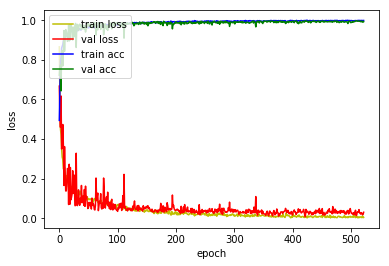

3183/3183 [==============================] - 3s 935us/sample - loss: 10.6451 - acc: 0.3380
Loss: 10.645130489546318 Accuracy: 0.33804587

Epoch 1/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.7418 - acc: 0.3244

Epoch 00001: val_loss improved from inf to 0.74184, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_5_conv_checkpoint/001-0.7418.hdf5
81/81 [==============================] - 24s 297ms/step - loss: 0.8988 - acc: 0.5000 - val_loss: 0.7418 - val_acc: 0.3244
Epoch 2/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.3538 - acc: 0.8559

Epoch 00002: val_loss improved from 0.74184 to 0.35377, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_5_conv_checkpoint/002-0.3538.hdf5
81/81 [==============================] - 21s 259ms/step - loss: 0.5788 - acc: 0.6865 - val_loss: 0.3538 - val_acc: 0.8559
Epoch 3/10000
3200/3183 [===============

81/81 [==============================] - 22s 271ms/step - loss: 0.1562 - acc: 0.9438 - val_loss: 0.0686 - val_acc: 0.9825
Epoch 15/10000
3200/3183 [==============================] - 22s 7ms/sample - loss: 0.0625 - acc: 0.9819

Epoch 00015: val_loss improved from 0.06859 to 0.06251, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_5_conv_checkpoint/015-0.0625.hdf5
81/81 [==============================] - 27s 329ms/step - loss: 0.1525 - acc: 0.9457 - val_loss: 0.0625 - val_acc: 0.9819
Epoch 16/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0649 - acc: 0.9844

Epoch 00016: val_loss did not improve from 0.06251
81/81 [==============================] - 24s 294ms/step - loss: 0.1573 - acc: 0.9382 - val_loss: 0.0649 - val_acc: 0.9844
Epoch 17/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.3933 - acc: 0.8219

Epoch 00017: val_loss did not improve from 0.06251
81/81 [=======================

Epoch 30/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.3651 - acc: 0.8375

Epoch 00030: val_loss did not improve from 0.06078
81/81 [==============================] - 23s 288ms/step - loss: 0.1201 - acc: 0.9578 - val_loss: 0.3651 - val_acc: 0.8375
Epoch 31/10000
3200/3183 [==============================] - 14s 4ms/sample - loss: 0.1059 - acc: 0.9625

Epoch 00031: val_loss did not improve from 0.06078
81/81 [==============================] - 22s 266ms/step - loss: 0.1201 - acc: 0.9562 - val_loss: 0.1059 - val_acc: 0.9625
Epoch 32/10000
3200/3183 [==============================] - 18s 5ms/sample - loss: 0.0600 - acc: 0.9775

Epoch 00032: val_loss improved from 0.06078 to 0.05999, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_5_conv_checkpoint/032-0.0600.hdf5
81/81 [==============================] - 21s 265ms/step - loss: 0.1105 - acc: 0.9621 - val_loss: 0.0600 - val_acc: 0.9775
Epoch 33/10000
3200/3183 [====

3200/3183 [==============================] - 15s 5ms/sample - loss: 0.0676 - acc: 0.97500s - loss: 0.0649 - acc: 0.975

Epoch 00045: val_loss did not improve from 0.05250
81/81 [==============================] - 22s 271ms/step - loss: 0.0823 - acc: 0.9711 - val_loss: 0.0676 - val_acc: 0.9750
Epoch 46/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0796 - acc: 0.9769

Epoch 00046: val_loss did not improve from 0.05250
81/81 [==============================] - 22s 268ms/step - loss: 0.0801 - acc: 0.9693 - val_loss: 0.0796 - val_acc: 0.9769
Epoch 47/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0515 - acc: 0.9850

Epoch 00047: val_loss improved from 0.05250 to 0.05153, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_5_conv_checkpoint/047-0.0515.hdf5
81/81 [==============================] - 23s 286ms/step - loss: 0.1042 - acc: 0.9621 - val_loss: 0.0515 - val_acc: 0.9850
Epoch 48/10000


3200/3183 [==============================] - 18s 6ms/sample - loss: 0.1151 - acc: 0.9544

Epoch 00060: val_loss did not improve from 0.03966
81/81 [==============================] - 22s 268ms/step - loss: 0.0768 - acc: 0.9777 - val_loss: 0.1151 - val_acc: 0.9544
Epoch 61/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0514 - acc: 0.9850

Epoch 00061: val_loss did not improve from 0.03966
81/81 [==============================] - 23s 289ms/step - loss: 0.0795 - acc: 0.9742 - val_loss: 0.0514 - val_acc: 0.9850
Epoch 62/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.1026 - acc: 0.9600

Epoch 00062: val_loss did not improve from 0.03966
81/81 [==============================] - 22s 270ms/step - loss: 0.0678 - acc: 0.9749 - val_loss: 0.1026 - val_acc: 0.9600
Epoch 63/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0723 - acc: 0.9716

Epoch 00063: val_loss did not improve from 0.03966
81/81 [==================

3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0516 - acc: 0.9800

Epoch 00075: val_loss did not improve from 0.03966
81/81 [==============================] - 21s 262ms/step - loss: 0.0450 - acc: 0.9851 - val_loss: 0.0516 - val_acc: 0.9800
Epoch 76/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0530 - acc: 0.9900

Epoch 00076: val_loss did not improve from 0.03966
81/81 [==============================] - 22s 266ms/step - loss: 0.0554 - acc: 0.9808 - val_loss: 0.0530 - val_acc: 0.9900
Epoch 77/10000
3200/3183 [==============================] - 13s 4ms/sample - loss: 0.1268 - acc: 0.9566

Epoch 00077: val_loss did not improve from 0.03966
81/81 [==============================] - 20s 247ms/step - loss: 0.0762 - acc: 0.9687 - val_loss: 0.1268 - val_acc: 0.9566
Epoch 78/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0869 - acc: 0.9684

Epoch 00078: val_loss did not improve from 0.03966
81/81 [==================

Epoch 91/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0577 - acc: 0.9725

Epoch 00091: val_loss did not improve from 0.03728
81/81 [==============================] - 21s 263ms/step - loss: 0.0478 - acc: 0.9848 - val_loss: 0.0577 - val_acc: 0.9725
Epoch 92/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0480 - acc: 0.9850

Epoch 00092: val_loss did not improve from 0.03728
81/81 [==============================] - 22s 268ms/step - loss: 0.0376 - acc: 0.9873 - val_loss: 0.0480 - val_acc: 0.9850
Epoch 93/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0393 - acc: 0.9850

Epoch 00093: val_loss did not improve from 0.03728
81/81 [==============================] - 24s 290ms/step - loss: 0.0496 - acc: 0.9842 - val_loss: 0.0393 - val_acc: 0.9850
Epoch 94/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0741 - acc: 0.9675

Epoch 00094: val_loss did not improve from 0.03728
81/81 [===

3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0471 - acc: 0.9825

Epoch 00106: val_loss did not improve from 0.02965
81/81 [==============================] - 23s 290ms/step - loss: 0.0464 - acc: 0.9860 - val_loss: 0.0471 - val_acc: 0.9825
Epoch 107/10000
3200/3183 [==============================] - 21s 7ms/sample - loss: 0.0607 - acc: 0.9750

Epoch 00107: val_loss did not improve from 0.02965
81/81 [==============================] - 25s 311ms/step - loss: 0.0406 - acc: 0.9851 - val_loss: 0.0607 - val_acc: 0.9750
Epoch 108/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0511 - acc: 0.9825

Epoch 00108: val_loss did not improve from 0.02965
81/81 [==============================] - 23s 284ms/step - loss: 0.0371 - acc: 0.9870 - val_loss: 0.0511 - val_acc: 0.9825
Epoch 109/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0480 - acc: 0.9825

Epoch 00109: val_loss did not improve from 0.02965
81/81 [===============

3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0297 - acc: 0.9925

Epoch 00122: val_loss did not improve from 0.02965
81/81 [==============================] - 24s 300ms/step - loss: 0.0482 - acc: 0.9823 - val_loss: 0.0297 - val_acc: 0.9925
Epoch 123/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0398 - acc: 0.9884

Epoch 00123: val_loss did not improve from 0.02965
81/81 [==============================] - 22s 274ms/step - loss: 0.0311 - acc: 0.9910 - val_loss: 0.0398 - val_acc: 0.9884
Epoch 124/10000
3200/3183 [==============================] - 21s 6ms/sample - loss: 0.0322 - acc: 0.9925

Epoch 00124: val_loss did not improve from 0.02965
81/81 [==============================] - 25s 308ms/step - loss: 0.0241 - acc: 0.9913 - val_loss: 0.0322 - val_acc: 0.9925
Epoch 125/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0432 - acc: 0.9850

Epoch 00125: val_loss did not improve from 0.02965
81/81 [===============

3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0317 - acc: 0.9881

Epoch 00137: val_loss did not improve from 0.02965
81/81 [==============================] - 23s 285ms/step - loss: 0.0297 - acc: 0.9894 - val_loss: 0.0317 - val_acc: 0.9881
Epoch 138/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0443 - acc: 0.9856

Epoch 00138: val_loss did not improve from 0.02965
81/81 [==============================] - 23s 279ms/step - loss: 0.0259 - acc: 0.9938 - val_loss: 0.0443 - val_acc: 0.9856
Epoch 139/10000
3200/3183 [==============================] - 23s 7ms/sample - loss: 0.0305 - acc: 0.9900

Epoch 00139: val_loss did not improve from 0.02965
81/81 [==============================] - 29s 364ms/step - loss: 0.0301 - acc: 0.9879 - val_loss: 0.0305 - val_acc: 0.9900
Epoch 140/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0417 - acc: 0.9825

Epoch 00140: val_loss did not improve from 0.02965
81/81 [===============

3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0338 - acc: 0.9894

Epoch 00152: val_loss did not improve from 0.02116
81/81 [==============================] - 25s 307ms/step - loss: 0.0186 - acc: 0.9929 - val_loss: 0.0338 - val_acc: 0.9894
Epoch 153/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0465 - acc: 0.9850

Epoch 00153: val_loss did not improve from 0.02116
81/81 [==============================] - 22s 266ms/step - loss: 0.0218 - acc: 0.9938 - val_loss: 0.0465 - val_acc: 0.9850
Epoch 154/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0499 - acc: 0.9794

Epoch 00154: val_loss did not improve from 0.02116
81/81 [==============================] - 22s 267ms/step - loss: 0.0161 - acc: 0.9960 - val_loss: 0.0499 - val_acc: 0.9794
Epoch 155/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0358 - acc: 0.9937

Epoch 00155: val_loss did not improve from 0.02116
81/81 [===============

3200/3183 [==============================] - 22s 7ms/sample - loss: 0.0436 - acc: 0.9825

Epoch 00168: val_loss did not improve from 0.02116
81/81 [==============================] - 26s 318ms/step - loss: 0.0178 - acc: 0.9953 - val_loss: 0.0436 - val_acc: 0.9825
Epoch 169/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0359 - acc: 0.9900

Epoch 00169: val_loss did not improve from 0.02116
81/81 [==============================] - 23s 288ms/step - loss: 0.0236 - acc: 0.9913 - val_loss: 0.0359 - val_acc: 0.9900
Epoch 170/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0311 - acc: 0.9950

Epoch 00170: val_loss did not improve from 0.02116
81/81 [==============================] - 21s 264ms/step - loss: 0.0106 - acc: 0.9966 - val_loss: 0.0311 - val_acc: 0.9950
Epoch 171/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0365 - acc: 0.9931

Epoch 00171: val_loss did not improve from 0.02116
81/81 [===============

3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0354 - acc: 0.9950

Epoch 00183: val_loss did not improve from 0.02069
81/81 [==============================] - 25s 306ms/step - loss: 0.0236 - acc: 0.9935 - val_loss: 0.0354 - val_acc: 0.9950
Epoch 184/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0313 - acc: 0.9884

Epoch 00184: val_loss did not improve from 0.02069
81/81 [==============================] - 24s 300ms/step - loss: 0.0171 - acc: 0.9947 - val_loss: 0.0313 - val_acc: 0.9884
Epoch 185/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0253 - acc: 0.9937

Epoch 00185: val_loss did not improve from 0.02069
81/81 [==============================] - 23s 281ms/step - loss: 0.0143 - acc: 0.9950 - val_loss: 0.0253 - val_acc: 0.9937
Epoch 186/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0253 - acc: 0.9931

Epoch 00186: val_loss did not improve from 0.02069
81/81 [===============

Epoch 199/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0186 - acc: 0.9875

Epoch 00199: val_loss did not improve from 0.01627
81/81 [==============================] - 22s 271ms/step - loss: 0.0191 - acc: 0.9935 - val_loss: 0.0186 - val_acc: 0.9875
Epoch 200/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0196 - acc: 0.9922

Epoch 00200: val_loss did not improve from 0.01627
81/81 [==============================] - 23s 282ms/step - loss: 0.0277 - acc: 0.9919 - val_loss: 0.0196 - val_acc: 0.9922
Epoch 201/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0180 - acc: 0.9900

Epoch 00201: val_loss did not improve from 0.01627
81/81 [==============================] - 27s 334ms/step - loss: 0.0115 - acc: 0.9972 - val_loss: 0.0180 - val_acc: 0.9900
Epoch 202/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0277 - acc: 0.9850

Epoch 00202: val_loss did not improve from 0.01627
81/81 

3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0327 - acc: 0.9834

Epoch 00214: val_loss did not improve from 0.00682
81/81 [==============================] - 22s 276ms/step - loss: 0.0150 - acc: 0.9950 - val_loss: 0.0327 - val_acc: 0.9834
Epoch 215/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0404 - acc: 0.9825

Epoch 00215: val_loss did not improve from 0.00682
81/81 [==============================] - 23s 290ms/step - loss: 0.0131 - acc: 0.9966 - val_loss: 0.0404 - val_acc: 0.9825
Epoch 216/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0244 - acc: 0.9912

Epoch 00216: val_loss did not improve from 0.00682
81/81 [==============================] - 22s 271ms/step - loss: 0.0100 - acc: 0.9969 - val_loss: 0.0244 - val_acc: 0.9912
Epoch 217/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0234 - acc: 0.9975

Epoch 00217: val_loss did not improve from 0.00682
81/81 [===============

3200/3183 [==============================] - 14s 4ms/sample - loss: 0.0115 - acc: 0.9975

Epoch 00229: val_loss did not improve from 0.00682
81/81 [==============================] - 23s 278ms/step - loss: 0.0233 - acc: 0.9938 - val_loss: 0.0115 - val_acc: 0.9975
Epoch 230/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0316 - acc: 0.9950s may duplicate your 

Epoch 00230: val_loss did not improve from 0.00682
81/81 [==============================] - 21s 259ms/step - loss: 0.0122 - acc: 0.9978 - val_loss: 0.0316 - val_acc: 0.9950
Epoch 231/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0325 - acc: 0.9941

Epoch 00231: val_loss did not improve from 0.00682
81/81 [==============================] - 24s 302ms/step - loss: 0.0074 - acc: 0.9978 - val_loss: 0.0325 - val_acc: 0.9941
Epoch 232/10000
3200/3183 [==============================] - 15s 5ms/sample - loss: 0.0200 - acc: 0.9947

Epoch 00232: val_loss did not improve from 0.00682
8

3200/3183 [==============================] - 23s 7ms/sample - loss: 0.0242 - acc: 0.9950

Epoch 00245: val_loss did not improve from 0.00682
81/81 [==============================] - 27s 333ms/step - loss: 0.0096 - acc: 0.9966 - val_loss: 0.0242 - val_acc: 0.9950
Epoch 246/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0237 - acc: 0.9900

Epoch 00246: val_loss did not improve from 0.00682
81/81 [==============================] - 22s 276ms/step - loss: 0.0136 - acc: 0.9960 - val_loss: 0.0237 - val_acc: 0.9900
Epoch 247/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0288 - acc: 0.9925

Epoch 00247: val_loss did not improve from 0.00682
81/81 [==============================] - 22s 275ms/step - loss: 0.0124 - acc: 0.9960 - val_loss: 0.0288 - val_acc: 0.9925
Epoch 248/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0163 - acc: 0.9925

Epoch 00248: val_loss did not improve from 0.00682
81/81 [===============

3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0194 - acc: 0.9950

Epoch 00260: val_loss did not improve from 0.00682
81/81 [==============================] - 22s 277ms/step - loss: 0.0108 - acc: 0.9972 - val_loss: 0.0194 - val_acc: 0.9950
Epoch 261/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0130 - acc: 0.9944

Epoch 00261: val_loss did not improve from 0.00682
81/81 [==============================] - 25s 314ms/step - loss: 0.0097 - acc: 0.9963 - val_loss: 0.0130 - val_acc: 0.9944
Epoch 262/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0300 - acc: 0.9950

Epoch 00262: val_loss did not improve from 0.00682
81/81 [==============================] - 24s 290ms/step - loss: 0.0099 - acc: 0.9966 - val_loss: 0.0300 - val_acc: 0.9950
Epoch 263/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0124 - acc: 0.9969

Epoch 00263: val_loss did not improve from 0.00682
81/81 [===============

3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0666 - acc: 0.9925

Epoch 00276: val_loss did not improve from 0.00682
81/81 [==============================] - 22s 267ms/step - loss: 0.0147 - acc: 0.9950 - val_loss: 0.0666 - val_acc: 0.9925
Epoch 277/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0250 - acc: 0.9925

Epoch 00277: val_loss did not improve from 0.00682
81/81 [==============================] - 22s 273ms/step - loss: 0.0113 - acc: 0.9960 - val_loss: 0.0250 - val_acc: 0.9925
Epoch 278/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0251 - acc: 0.9925

Epoch 00278: val_loss did not improve from 0.00682
81/81 [==============================] - 23s 280ms/step - loss: 0.0102 - acc: 0.9969 - val_loss: 0.0251 - val_acc: 0.9925
Epoch 279/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0420 - acc: 0.9900

Epoch 00279: val_loss did not improve from 0.00682
81/81 [===============

3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0199 - acc: 0.9969

Epoch 00291: val_loss did not improve from 0.00682
81/81 [==============================] - 21s 264ms/step - loss: 0.0093 - acc: 0.9981 - val_loss: 0.0199 - val_acc: 0.9969
Epoch 292/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0216 - acc: 0.9947

Epoch 00292: val_loss did not improve from 0.00682
81/81 [==============================] - 24s 290ms/step - loss: 0.0064 - acc: 0.9978 - val_loss: 0.0216 - val_acc: 0.9947
Epoch 293/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0109 - acc: 0.9975

Epoch 00293: val_loss did not improve from 0.00682
81/81 [==============================] - 23s 285ms/step - loss: 0.0111 - acc: 0.9960 - val_loss: 0.0109 - val_acc: 0.9975
Epoch 294/10000
3200/3183 [==============================] - 18s 5ms/sample - loss: 0.0276 - acc: 0.9975

Epoch 00294: val_loss did not improve from 0.00682
81/81 [===============

Epoch 307/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0136 - acc: 0.9944

Epoch 00307: val_loss did not improve from 0.00465
81/81 [==============================] - 22s 267ms/step - loss: 0.0070 - acc: 0.9975 - val_loss: 0.0136 - val_acc: 0.9944
Epoch 308/10000
3190/3183 [==============================] - 19s 6ms/sample - loss: 0.0285 - acc: 0.9950

Epoch 00308: val_loss did not improve from 0.00465
81/81 [==============================] - 23s 281ms/step - loss: 0.0168 - acc: 0.9935 - val_loss: 0.0285 - val_acc: 0.9950
Epoch 309/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0219 - acc: 0.9950

Epoch 00309: val_loss did not improve from 0.00465
81/81 [==============================] - 21s 264ms/step - loss: 0.0053 - acc: 0.9981 - val_loss: 0.0219 - val_acc: 0.9950
Epoch 310/10000
3200/3183 [==============================] - 24s 8ms/sample - loss: 0.0251 - acc: 0.9950

Epoch 00310: val_loss did not improve from 0.00465
81/81 

3200/3183 [==============================] - 13s 4ms/sample - loss: 0.0152 - acc: 0.9975

Epoch 00322: val_loss did not improve from 0.00465
81/81 [==============================] - 22s 268ms/step - loss: 0.0063 - acc: 0.9984 - val_loss: 0.0152 - val_acc: 0.9975
Epoch 323/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0246 - acc: 0.9966

Epoch 00323: val_loss did not improve from 0.00465
81/81 [==============================] - 22s 276ms/step - loss: 0.0034 - acc: 0.9994 - val_loss: 0.0246 - val_acc: 0.9966
Epoch 324/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0214 - acc: 0.9950

Epoch 00324: val_loss did not improve from 0.00465
81/81 [==============================] - 24s 295ms/step - loss: 0.0095 - acc: 0.9960 - val_loss: 0.0214 - val_acc: 0.9950
Epoch 325/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0229 - acc: 0.9950

Epoch 00325: val_loss did not improve from 0.00465
81/81 [===============

3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0179 - acc: 0.9944

Epoch 00338: val_loss did not improve from 0.00465
81/81 [==============================] - 21s 264ms/step - loss: 0.0074 - acc: 0.9988 - val_loss: 0.0179 - val_acc: 0.9944
Epoch 339/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0072 - acc: 0.9969

Epoch 00339: val_loss did not improve from 0.00465
81/81 [==============================] - 23s 289ms/step - loss: 0.0036 - acc: 0.9991 - val_loss: 0.0072 - val_acc: 0.9969
Epoch 340/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0134 - acc: 0.9975

Epoch 00340: val_loss did not improve from 0.00465
81/81 [==============================] - 23s 279ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0134 - val_acc: 0.9975
Epoch 341/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0177 - acc: 0.9944

Epoch 00341: val_loss did not improve from 0.00465
81/81 [===============

3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0136 - acc: 0.9969

Epoch 00353: val_loss did not improve from 0.00465
81/81 [==============================] - 22s 268ms/step - loss: 0.0039 - acc: 0.9984 - val_loss: 0.0136 - val_acc: 0.9969
Epoch 354/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0109 - acc: 0.9950

Epoch 00354: val_loss did not improve from 0.00465
81/81 [==============================] - 22s 267ms/step - loss: 0.0088 - acc: 0.9966 - val_loss: 0.0109 - val_acc: 0.9950
Epoch 355/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0374 - acc: 0.9856

Epoch 00355: val_loss did not improve from 0.00465
81/81 [==============================] - 22s 270ms/step - loss: 0.0086 - acc: 0.9969 - val_loss: 0.0374 - val_acc: 0.9856
Epoch 356/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0055 - acc: 0.9975

Epoch 00356: val_loss did not improve from 0.00465
81/81 [===============

3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0084 - acc: 0.9975

Epoch 00369: val_loss did not improve from 0.00465
81/81 [==============================] - 24s 295ms/step - loss: 0.0051 - acc: 0.9978 - val_loss: 0.0084 - val_acc: 0.9975
Epoch 370/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0277 - acc: 0.9900

Epoch 00370: val_loss did not improve from 0.00465
81/81 [==============================] - 22s 273ms/step - loss: 0.0052 - acc: 0.9988 - val_loss: 0.0277 - val_acc: 0.9900
Epoch 371/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0245 - acc: 0.9912

Epoch 00371: val_loss did not improve from 0.00465
81/81 [==============================] - 21s 265ms/step - loss: 0.0159 - acc: 0.9947 - val_loss: 0.0245 - val_acc: 0.9912
Epoch 372/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0167 - acc: 0.9950

Epoch 00372: val_loss did not improve from 0.00465
81/81 [===============

3200/3183 [==============================] - 21s 6ms/sample - loss: 0.0173 - acc: 0.9950

Epoch 00384: val_loss did not improve from 0.00465
81/81 [==============================] - 25s 307ms/step - loss: 0.0078 - acc: 0.9972 - val_loss: 0.0173 - val_acc: 0.9950
Epoch 385/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0250 - acc: 0.9950

Epoch 00385: val_loss did not improve from 0.00465
81/81 [==============================] - 22s 272ms/step - loss: 0.0066 - acc: 0.9984 - val_loss: 0.0250 - val_acc: 0.9950
Epoch 386/10000
3200/3183 [==============================] - 15s 5ms/sample - loss: 0.0182 - acc: 0.9919

Epoch 00386: val_loss did not improve from 0.00465
81/81 [==============================] - 24s 300ms/step - loss: 0.0048 - acc: 0.9981 - val_loss: 0.0182 - val_acc: 0.9919
Epoch 387/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0174 - acc: 0.9975

Epoch 00387: val_loss did not improve from 0.00465
81/81 [===============

Epoch 400/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0209 - acc: 0.9950

Epoch 00400: val_loss did not improve from 0.00465
81/81 [==============================] - 20s 246ms/step - loss: 0.0041 - acc: 0.9988 - val_loss: 0.0209 - val_acc: 0.9950
Epoch 401/10000
3200/3183 [==============================] - 15s 5ms/sample - loss: 0.0159 - acc: 0.9966

Epoch 00401: val_loss did not improve from 0.00465
81/81 [==============================] - 22s 273ms/step - loss: 0.0064 - acc: 0.9978 - val_loss: 0.0159 - val_acc: 0.9966
Epoch 402/10000
3200/3183 [==============================] - 15s 5ms/sample - loss: 0.0194 - acc: 0.9975

Epoch 00402: val_loss did not improve from 0.00465
81/81 [==============================] - 21s 261ms/step - loss: 0.0028 - acc: 0.9991 - val_loss: 0.0194 - val_acc: 0.9975
Epoch 403/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0336 - acc: 0.9950s may du

Epoch 00403: val_loss did not improve from 0.0046

3200/3183 [==============================] - 14s 4ms/sample - loss: 0.0119 - acc: 0.9972

Epoch 00415: val_loss did not improve from 0.00456
81/81 [==============================] - 23s 280ms/step - loss: 7.3275e-04 - acc: 1.0000 - val_loss: 0.0119 - val_acc: 0.9972
Epoch 416/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0388 - acc: 0.9950

Epoch 00416: val_loss did not improve from 0.00456
81/81 [==============================] - 22s 276ms/step - loss: 0.0014 - acc: 0.9997 - val_loss: 0.0388 - val_acc: 0.9950
Epoch 417/10000
3200/3183 [==============================] - 15s 5ms/sample - loss: 0.0281 - acc: 0.9925

Epoch 00417: val_loss did not improve from 0.00456
81/81 [==============================] - 21s 264ms/step - loss: 0.0067 - acc: 0.9984 - val_loss: 0.0281 - val_acc: 0.9925
Epoch 418/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0118 - acc: 0.9975

Epoch 00418: val_loss did not improve from 0.00456
81/81 [===========

3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0320 - acc: 0.9950

Epoch 00431: val_loss did not improve from 0.00456
81/81 [==============================] - 22s 272ms/step - loss: 8.1631e-04 - acc: 0.9997 - val_loss: 0.0320 - val_acc: 0.9950
Epoch 432/10000
3200/3183 [==============================] - 15s 5ms/sample - loss: 0.0305 - acc: 0.9950

Epoch 00432: val_loss did not improve from 0.00456
81/81 [==============================] - 23s 284ms/step - loss: 0.0040 - acc: 0.9984 - val_loss: 0.0305 - val_acc: 0.9950
Epoch 433/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0561 - acc: 0.9950

Epoch 00433: val_loss did not improve from 0.00456
81/81 [==============================] - 24s 292ms/step - loss: 0.0052 - acc: 0.9984 - val_loss: 0.0561 - val_acc: 0.9950
Epoch 434/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0375 - acc: 0.9925

Epoch 00434: val_loss did not improve from 0.00456
81/81 [===========

3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0193 - acc: 0.9947

Epoch 00446: val_loss did not improve from 0.00456
81/81 [==============================] - 24s 298ms/step - loss: 0.0024 - acc: 0.9997 - val_loss: 0.0193 - val_acc: 0.9947
Epoch 447/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0083 - acc: 0.9975s may duplicate your

Epoch 00447: val_loss did not improve from 0.00456
81/81 [==============================] - 22s 267ms/step - loss: 0.0054 - acc: 0.9975 - val_loss: 0.0083 - val_acc: 0.9975
Epoch 448/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0134 - acc: 0.9975

Epoch 00448: val_loss did not improve from 0.00456
81/81 [==============================] - 22s 266ms/step - loss: 0.0051 - acc: 0.9984 - val_loss: 0.0134 - val_acc: 0.9975
Epoch 449/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0314 - acc: 0.9894

Epoch 00449: val_loss did not improve from 0.00456
81

3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0060 - acc: 0.9972

Epoch 00462: val_loss did not improve from 0.00456
81/81 [==============================] - 22s 275ms/step - loss: 0.0077 - acc: 0.9960 - val_loss: 0.0060 - val_acc: 0.9972
Epoch 463/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0183 - acc: 0.9937

Epoch 00463: val_loss did not improve from 0.00456
81/81 [==============================] - 22s 274ms/step - loss: 0.0053 - acc: 0.9984 - val_loss: 0.0183 - val_acc: 0.9937
Epoch 464/10000
3200/3183 [==============================] - 21s 6ms/sample - loss: 0.0227 - acc: 0.9944

Epoch 00464: val_loss did not improve from 0.00456
81/81 [==============================] - 27s 331ms/step - loss: 0.0037 - acc: 0.9978 - val_loss: 0.0227 - val_acc: 0.9944
Epoch 465/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0099 - acc: 0.9944

Epoch 00465: val_loss did not improve from 0.00456
81/81 [===============

3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0245 - acc: 0.9925

Epoch 00477: val_loss did not improve from 0.00456
81/81 [==============================] - 22s 276ms/step - loss: 0.0059 - acc: 0.9984 - val_loss: 0.0245 - val_acc: 0.9925
Epoch 478/10000
3200/3183 [==============================] - 12s 4ms/sample - loss: 0.0369 - acc: 0.9950

Epoch 00478: val_loss did not improve from 0.00456
81/81 [==============================] - 22s 267ms/step - loss: 0.0101 - acc: 0.9972 - val_loss: 0.0369 - val_acc: 0.9950
Epoch 479/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0126 - acc: 0.9950

Epoch 00479: val_loss did not improve from 0.00456
81/81 [==============================] - 22s 270ms/step - loss: 0.0053 - acc: 0.9988 - val_loss: 0.0126 - val_acc: 0.9950
Epoch 480/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0070 - acc: 0.9950

Epoch 00480: val_loss did not improve from 0.00456
81/81 [===============

3200/3183 [==============================] - 22s 7ms/sample - loss: 0.0140 - acc: 0.9944

Epoch 00493: val_loss did not improve from 0.00456
81/81 [==============================] - 26s 321ms/step - loss: 7.8182e-04 - acc: 0.9997 - val_loss: 0.0140 - val_acc: 0.9944
Epoch 494/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0310 - acc: 0.9947

Epoch 00494: val_loss did not improve from 0.00456
81/81 [==============================] - 21s 260ms/step - loss: 0.0042 - acc: 0.9984 - val_loss: 0.0310 - val_acc: 0.9947
Epoch 495/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0238 - acc: 0.9944

Epoch 00495: val_loss did not improve from 0.00456
81/81 [==============================] - 22s 269ms/step - loss: 0.0033 - acc: 0.9994 - val_loss: 0.0238 - val_acc: 0.9944
Epoch 496/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0131 - acc: 0.9972

Epoch 00496: val_loss did not improve from 0.00456
81/81 [===========

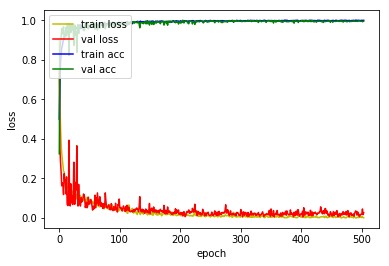

3183/3183 [==============================] - 3s 900us/sample - loss: 10.6499 - acc: 0.3374
Loss: 10.649943708605003 Accuracy: 0.33741754

Epoch 1/10000
3200/3183 [==============================] - 18s 5ms/sample - loss: 0.6617 - acc: 0.8575

Epoch 00001: val_loss improved from inf to 0.66169, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_6_conv_checkpoint/001-0.6617.hdf5
81/81 [==============================] - 23s 290ms/step - loss: 0.9534 - acc: 0.4994 - val_loss: 0.6617 - val_acc: 0.8575
Epoch 2/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.8002 - acc: 0.5125

Epoch 00002: val_loss did not improve from 0.66169
81/81 [==============================] - 23s 278ms/step - loss: 0.7383 - acc: 0.5574 - val_loss: 0.8002 - val_acc: 0.5125
Epoch 3/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.7100 - acc: 0.6194

Epoch 00003: val_loss did not improve from 0.66169
81/81 [==============

3200/3183 [==============================] - 18s 5ms/sample - loss: 0.0654 - acc: 0.9825

Epoch 00014: val_loss improved from 0.07427 to 0.06537, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_6_conv_checkpoint/014-0.0654.hdf5
81/81 [==============================] - 21s 265ms/step - loss: 0.1594 - acc: 0.9444 - val_loss: 0.0654 - val_acc: 0.9825
Epoch 15/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.1492 - acc: 0.9400

Epoch 00015: val_loss did not improve from 0.06537
81/81 [==============================] - 21s 261ms/step - loss: 0.1404 - acc: 0.9516 - val_loss: 0.1492 - val_acc: 0.9400
Epoch 16/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.1928 - acc: 0.9147

Epoch 00016: val_loss did not improve from 0.06537
81/81 [==============================] - 24s 296ms/step - loss: 0.1455 - acc: 0.9475 - val_loss: 0.1928 - val_acc: 0.9147
Epoch 17/10000
3200/3183 [===================

3200/3183 [==============================] - 22s 7ms/sample - loss: 0.1031 - acc: 0.9531

Epoch 00029: val_loss did not improve from 0.05944
81/81 [==============================] - 27s 329ms/step - loss: 0.0993 - acc: 0.9671 - val_loss: 0.1031 - val_acc: 0.9531
Epoch 30/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0751 - acc: 0.9688

Epoch 00030: val_loss did not improve from 0.05944
81/81 [==============================] - 26s 319ms/step - loss: 0.0925 - acc: 0.9677 - val_loss: 0.0751 - val_acc: 0.9688
Epoch 31/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0438 - acc: 0.9900

Epoch 00031: val_loss improved from 0.05944 to 0.04384, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_6_conv_checkpoint/031-0.0438.hdf5
81/81 [==============================] - 23s 288ms/step - loss: 0.0895 - acc: 0.9668 - val_loss: 0.0438 - val_acc: 0.9900
Epoch 32/10000
3200/3183 [===================

3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0505 - acc: 0.9825

Epoch 00044: val_loss did not improve from 0.03353
81/81 [==============================] - 21s 265ms/step - loss: 0.0730 - acc: 0.9758 - val_loss: 0.0505 - val_acc: 0.9825
Epoch 45/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0378 - acc: 0.9812

Epoch 00045: val_loss did not improve from 0.03353
81/81 [==============================] - 22s 272ms/step - loss: 0.0674 - acc: 0.9770 - val_loss: 0.0378 - val_acc: 0.9812
Epoch 46/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0475 - acc: 0.9769

Epoch 00046: val_loss did not improve from 0.03353
81/81 [==============================] - 23s 284ms/step - loss: 0.0685 - acc: 0.9777 - val_loss: 0.0475 - val_acc: 0.9769
Epoch 47/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0428 - acc: 0.9825

Epoch 00047: val_loss did not improve from 0.03353
81/81 [==================

Epoch 60/10000
3200/3183 [==============================] - 22s 7ms/sample - loss: 0.0877 - acc: 0.9553

Epoch 00060: val_loss did not improve from 0.02162
81/81 [==============================] - 26s 325ms/step - loss: 0.0611 - acc: 0.9808 - val_loss: 0.0877 - val_acc: 0.9553
Epoch 61/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0347 - acc: 0.9875

Epoch 00061: val_loss did not improve from 0.02162
81/81 [==============================] - 22s 275ms/step - loss: 0.0415 - acc: 0.9863 - val_loss: 0.0347 - val_acc: 0.9875
Epoch 62/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0468 - acc: 0.9806

Epoch 00062: val_loss did not improve from 0.02162
81/81 [==============================] - 21s 265ms/step - loss: 0.0468 - acc: 0.9857 - val_loss: 0.0468 - val_acc: 0.9806
Epoch 63/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0534 - acc: 0.9703

Epoch 00063: val_loss did not improve from 0.02162
81/81 [===

3200/3183 [==============================] - 18s 5ms/sample - loss: 0.0438 - acc: 0.9809

Epoch 00075: val_loss did not improve from 0.02162
81/81 [==============================] - 22s 268ms/step - loss: 0.0362 - acc: 0.9910 - val_loss: 0.0438 - val_acc: 0.9809
Epoch 76/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0527 - acc: 0.9800

Epoch 00076: val_loss did not improve from 0.02162
81/81 [==============================] - 22s 266ms/step - loss: 0.0403 - acc: 0.9888 - val_loss: 0.0527 - val_acc: 0.9800
Epoch 77/10000
3200/3183 [==============================] - 21s 6ms/sample - loss: 0.0265 - acc: 0.9906

Epoch 00077: val_loss did not improve from 0.02162
81/81 [==============================] - 24s 301ms/step - loss: 0.0528 - acc: 0.9820 - val_loss: 0.0265 - val_acc: 0.9906
Epoch 78/10000
3200/3183 [==============================] - 21s 7ms/sample - loss: 0.0546 - acc: 0.9819

Epoch 00078: val_loss did not improve from 0.02162
81/81 [==================

3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0252 - acc: 0.9931

Epoch 00091: val_loss did not improve from 0.02162
81/81 [==============================] - 22s 277ms/step - loss: 0.0264 - acc: 0.9922 - val_loss: 0.0252 - val_acc: 0.9931
Epoch 92/10000
3190/3183 [==============================] - 15s 5ms/sample - loss: 0.0195 - acc: 0.9900

Epoch 00092: val_loss improved from 0.02162 to 0.01954, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_6_conv_checkpoint/092-0.0195.hdf5
81/81 [==============================] - 21s 261ms/step - loss: 0.0265 - acc: 0.9922 - val_loss: 0.0195 - val_acc: 0.9900
Epoch 93/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0214 - acc: 0.9950

Epoch 00093: val_loss did not improve from 0.01954
81/81 [==============================] - 22s 268ms/step - loss: 0.0316 - acc: 0.9919 - val_loss: 0.0214 - val_acc: 0.9950
Epoch 94/10000
3200/3183 [===================

3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0147 - acc: 0.9950

Epoch 00106: val_loss improved from 0.01756 to 0.01472, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_6_conv_checkpoint/106-0.0147.hdf5
81/81 [==============================] - 21s 258ms/step - loss: 0.0240 - acc: 0.9926 - val_loss: 0.0147 - val_acc: 0.9950
Epoch 107/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0233 - acc: 0.9969

Epoch 00107: val_loss did not improve from 0.01472
81/81 [==============================] - 22s 268ms/step - loss: 0.0213 - acc: 0.9929 - val_loss: 0.0233 - val_acc: 0.9969
Epoch 108/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0287 - acc: 0.9919

Epoch 00108: val_loss did not improve from 0.01472
81/81 [==============================] - 23s 282ms/step - loss: 0.0336 - acc: 0.9894 - val_loss: 0.0287 - val_acc: 0.9919
Epoch 109/10000
3200/3183 [================

3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0143 - acc: 0.9950

Epoch 00121: val_loss improved from 0.01472 to 0.01434, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_6_conv_checkpoint/121-0.0143.hdf5
81/81 [==============================] - 22s 270ms/step - loss: 0.0213 - acc: 0.9922 - val_loss: 0.0143 - val_acc: 0.9950
Epoch 122/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0189 - acc: 0.9925

Epoch 00122: val_loss did not improve from 0.01434
81/81 [==============================] - 22s 273ms/step - loss: 0.0191 - acc: 0.9941 - val_loss: 0.0189 - val_acc: 0.9925
Epoch 123/10000
3200/3183 [==============================] - 21s 6ms/sample - loss: 0.0327 - acc: 0.9872

Epoch 00123: val_loss did not improve from 0.01434
81/81 [==============================] - 25s 303ms/step - loss: 0.0279 - acc: 0.9916 - val_loss: 0.0327 - val_acc: 0.9872
Epoch 124/10000
3200/3183 [================

3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0198 - acc: 0.9975

Epoch 00136: val_loss did not improve from 0.01187
81/81 [==============================] - 21s 265ms/step - loss: 0.0144 - acc: 0.9981 - val_loss: 0.0198 - val_acc: 0.9975
Epoch 137/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0221 - acc: 0.9941

Epoch 00137: val_loss did not improve from 0.01187
81/81 [==============================] - 21s 260ms/step - loss: 0.0194 - acc: 0.9950 - val_loss: 0.0221 - val_acc: 0.9941
Epoch 138/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0212 - acc: 0.9956

Epoch 00138: val_loss did not improve from 0.01187
81/81 [==============================] - 24s 292ms/step - loss: 0.0239 - acc: 0.9938 - val_loss: 0.0212 - val_acc: 0.9956
Epoch 139/10000
3200/3183 [==============================] - 18s 5ms/sample - loss: 0.0219 - acc: 0.9975

Epoch 00139: val_loss did not improve from 0.01187
81/81 [===============

3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0353 - acc: 0.9950

Epoch 00152: val_loss did not improve from 0.01187
81/81 [==============================] - 23s 284ms/step - loss: 0.0142 - acc: 0.9963 - val_loss: 0.0353 - val_acc: 0.9950
Epoch 153/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0280 - acc: 0.9925

Epoch 00153: val_loss did not improve from 0.01187
81/81 [==============================] - 22s 269ms/step - loss: 0.0111 - acc: 0.9966 - val_loss: 0.0280 - val_acc: 0.9925
Epoch 154/10000
3200/3183 [==============================] - 21s 6ms/sample - loss: 0.0190 - acc: 0.9950

Epoch 00154: val_loss did not improve from 0.01187
81/81 [==============================] - 25s 304ms/step - loss: 0.0114 - acc: 0.9966 - val_loss: 0.0190 - val_acc: 0.9950
Epoch 155/10000
3200/3183 [==============================] - 18s 5ms/sample - loss: 0.0408 - acc: 0.9950

Epoch 00155: val_loss did not improve from 0.01187
81/81 [===============

3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0393 - acc: 0.9950

Epoch 00167: val_loss did not improve from 0.00778
81/81 [==============================] - 22s 268ms/step - loss: 0.0109 - acc: 0.9969 - val_loss: 0.0393 - val_acc: 0.9950
Epoch 168/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0246 - acc: 0.9937

Epoch 00168: val_loss did not improve from 0.00778
81/81 [==============================] - 22s 271ms/step - loss: 0.0189 - acc: 0.9941 - val_loss: 0.0246 - val_acc: 0.9937
Epoch 169/10000
3200/3183 [==============================] - 25s 8ms/sample - loss: 0.0131 - acc: 0.99098s - loss: 0.0

Epoch 00169: val_loss did not improve from 0.00778
81/81 [==============================] - 30s 364ms/step - loss: 0.0141 - acc: 0.9950 - val_loss: 0.0131 - val_acc: 0.9909
Epoch 170/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0144 - acc: 0.9956

Epoch 00170: val_loss did not improve from 0.00778
81/81 [=

3200/3183 [==============================] - 22s 7ms/sample - loss: 0.0201 - acc: 0.9900

Epoch 00182: val_loss did not improve from 0.00778
81/81 [==============================] - 26s 316ms/step - loss: 0.0187 - acc: 0.9947 - val_loss: 0.0201 - val_acc: 0.9900
Epoch 183/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0242 - acc: 0.9950

Epoch 00183: val_loss did not improve from 0.00778
81/81 [==============================] - 22s 267ms/step - loss: 0.0173 - acc: 0.9966 - val_loss: 0.0242 - val_acc: 0.9950
Epoch 184/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0218 - acc: 0.9966

Epoch 00184: val_loss did not improve from 0.00778
81/81 [==============================] - 24s 292ms/step - loss: 0.0114 - acc: 0.9969 - val_loss: 0.0218 - val_acc: 0.9966
Epoch 185/10000
3200/3183 [==============================] - 22s 7ms/sample - loss: 0.0309 - acc: 0.9912

Epoch 00185: val_loss did not improve from 0.00778
81/81 [===============

3200/3183 [==============================] - 25s 8ms/sample - loss: 0.0200 - acc: 0.9950

Epoch 00198: val_loss did not improve from 0.00778
81/81 [==============================] - 29s 353ms/step - loss: 0.0098 - acc: 0.9984 - val_loss: 0.0200 - val_acc: 0.9950
Epoch 199/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0175 - acc: 0.9950

Epoch 00199: val_loss did not improve from 0.00778
81/81 [==============================] - 24s 301ms/step - loss: 0.0099 - acc: 0.9963 - val_loss: 0.0175 - val_acc: 0.9950
Epoch 200/10000
3200/3183 [==============================] - 24s 7ms/sample - loss: 0.0286 - acc: 0.9875

Epoch 00200: val_loss did not improve from 0.00778
81/81 [==============================] - 28s 341ms/step - loss: 0.0118 - acc: 0.9963 - val_loss: 0.0286 - val_acc: 0.9875
Epoch 201/10000
3200/3183 [==============================] - 14s 4ms/sample - loss: 0.0326 - acc: 0.9947

Epoch 00201: val_loss did not improve from 0.00778
81/81 [===============

3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0380 - acc: 0.9925

Epoch 00213: val_loss did not improve from 0.00280
81/81 [==============================] - 22s 268ms/step - loss: 0.0167 - acc: 0.9950 - val_loss: 0.0380 - val_acc: 0.9925
Epoch 214/10000
3200/3183 [==============================] - 29s 9ms/sample - loss: 0.0167 - acc: 0.9975

Epoch 00214: val_loss did not improve from 0.00280
81/81 [==============================] - 33s 411ms/step - loss: 0.0105 - acc: 0.9957 - val_loss: 0.0167 - val_acc: 0.9975
Epoch 215/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0264 - acc: 0.9944

Epoch 00215: val_loss did not improve from 0.00280
81/81 [==============================] - 25s 309ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0264 - val_acc: 0.9944
Epoch 216/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0316 - acc: 0.9975

Epoch 00216: val_loss did not improve from 0.00280
81/81 [===============

3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0636 - acc: 0.9950

Epoch 00229: val_loss did not improve from 0.00280
81/81 [==============================] - 22s 267ms/step - loss: 0.0050 - acc: 0.9978 - val_loss: 0.0636 - val_acc: 0.9950
Epoch 230/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0144 - acc: 0.9950

Epoch 00230: val_loss did not improve from 0.00280
81/81 [==============================] - 23s 279ms/step - loss: 0.0034 - acc: 0.9991 - val_loss: 0.0144 - val_acc: 0.9950
Epoch 231/10000
3200/3183 [==============================] - 24s 8ms/sample - loss: 0.0335 - acc: 0.9937

Epoch 00231: val_loss did not improve from 0.00280
81/81 [==============================] - 28s 348ms/step - loss: 0.0065 - acc: 0.9981 - val_loss: 0.0335 - val_acc: 0.9937
Epoch 232/10000
3200/3183 [==============================] - 22s 7ms/sample - loss: 0.0182 - acc: 0.9919

Epoch 00232: val_loss did not improve from 0.00280
81/81 [===============

3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0211 - acc: 0.9925

Epoch 00244: val_loss did not improve from 0.00280
81/81 [==============================] - 22s 272ms/step - loss: 0.0111 - acc: 0.9975 - val_loss: 0.0211 - val_acc: 0.9925
Epoch 245/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0152 - acc: 0.9941

Epoch 00245: val_loss did not improve from 0.00280
81/81 [==============================] - 24s 302ms/step - loss: 0.0136 - acc: 0.9941 - val_loss: 0.0152 - val_acc: 0.9941
Epoch 246/10000
3200/3183 [==============================] - 24s 8ms/sample - loss: 0.0539 - acc: 0.9925

Epoch 00246: val_loss did not improve from 0.00280
81/81 [==============================] - 31s 381ms/step - loss: 0.0016 - acc: 0.9997 - val_loss: 0.0539 - val_acc: 0.9925
Epoch 247/10000
3200/3183 [==============================] - 21s 6ms/sample - loss: 0.0308 - acc: 0.9950

Epoch 00247: val_loss did not improve from 0.00280
81/81 [===============

3200/3183 [==============================] - 22s 7ms/sample - loss: 0.0308 - acc: 0.9950

Epoch 00260: val_loss did not improve from 0.00280
81/81 [==============================] - 26s 325ms/step - loss: 0.0134 - acc: 0.9960 - val_loss: 0.0308 - val_acc: 0.9950
Epoch 261/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0536 - acc: 0.9950

Epoch 00261: val_loss did not improve from 0.00280
81/81 [==============================] - 22s 267ms/step - loss: 0.0019 - acc: 0.9997 - val_loss: 0.0536 - val_acc: 0.9950
Epoch 262/10000
3200/3183 [==============================] - 18s 5ms/sample - loss: 0.0164 - acc: 0.9953

Epoch 00262: val_loss did not improve from 0.00280
81/81 [==============================] - 22s 268ms/step - loss: 0.0083 - acc: 0.9978 - val_loss: 0.0164 - val_acc: 0.9953
Epoch 263/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0122 - acc: 0.9975

Epoch 00263: val_loss did not improve from 0.00280
81/81 [===============

3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0320 - acc: 0.9931

Epoch 00275: val_loss did not improve from 0.00280
81/81 [==============================] - 25s 303ms/step - loss: 0.0054 - acc: 0.9978 - val_loss: 0.0320 - val_acc: 0.9931
Epoch 276/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0377 - acc: 0.9950

Epoch 00276: val_loss did not improve from 0.00280
81/81 [==============================] - 26s 316ms/step - loss: 0.0059 - acc: 0.9978 - val_loss: 0.0377 - val_acc: 0.9950
Epoch 277/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0635 - acc: 0.9950

Epoch 00277: val_loss did not improve from 0.00280
81/81 [==============================] - 25s 308ms/step - loss: 0.0049 - acc: 0.9988 - val_loss: 0.0635 - val_acc: 0.9950
Epoch 278/10000
3200/3183 [==============================] - 29s 9ms/sample - loss: 0.0450 - acc: 0.9950

Epoch 00278: val_loss did not improve from 0.00280
81/81 [===============

3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0028 - acc: 1.0000

Epoch 00291: val_loss did not improve from 0.00280
81/81 [==============================] - 23s 287ms/step - loss: 0.0027 - acc: 0.9994 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 292/10000
3200/3183 [==============================] - 21s 7ms/sample - loss: 0.0247 - acc: 0.9975

Epoch 00292: val_loss did not improve from 0.00280
81/81 [==============================] - 25s 312ms/step - loss: 0.0015 - acc: 0.9997 - val_loss: 0.0247 - val_acc: 0.9975
Epoch 293/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0135 - acc: 0.9975

Epoch 00293: val_loss did not improve from 0.00280
81/81 [==============================] - 22s 274ms/step - loss: 0.0025 - acc: 0.9988 - val_loss: 0.0135 - val_acc: 0.9975
Epoch 294/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0301 - acc: 0.9975

Epoch 00294: val_loss did not improve from 0.00280
81/81 [===============

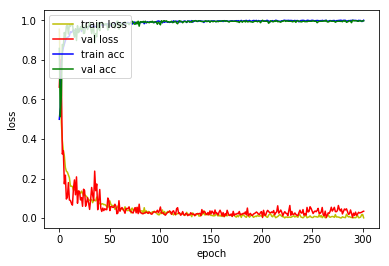

3183/3183 [==============================] - 3s 965us/sample - loss: 10.5307 - acc: 0.3384
Loss: 10.530664003067498 Accuracy: 0.33836004

Epoch 1/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.6398 - acc: 0.9200

Epoch 00001: val_loss improved from inf to 0.63982, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_7_conv_checkpoint/001-0.6398.hdf5
81/81 [==============================] - 26s 324ms/step - loss: 0.8598 - acc: 0.5047 - val_loss: 0.6398 - val_acc: 0.9200
Epoch 2/10000
3200/3183 [==============================] - 25s 8ms/sample - loss: 0.3961 - acc: 0.9150

Epoch 00002: val_loss improved from 0.63982 to 0.39606, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_7_conv_checkpoint/002-0.3961.hdf5
81/81 [==============================] - 30s 366ms/step - loss: 0.7218 - acc: 0.5472 - val_loss: 0.3961 - val_acc: 0.9150
Epoch 3/10000
3200/3183 [===============

3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0878 - acc: 0.9688

Epoch 00015: val_loss did not improve from 0.06048
81/81 [==============================] - 23s 286ms/step - loss: 0.1391 - acc: 0.9500 - val_loss: 0.0878 - val_acc: 0.9688
Epoch 16/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.1276 - acc: 0.9425

Epoch 00016: val_loss did not improve from 0.06048
81/81 [==============================] - 33s 406ms/step - loss: 0.1200 - acc: 0.9556 - val_loss: 0.1276 - val_acc: 0.9425
Epoch 17/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0798 - acc: 0.9700

Epoch 00017: val_loss did not improve from 0.06048
81/81 [==============================] - 25s 308ms/step - loss: 0.1135 - acc: 0.9581 - val_loss: 0.0798 - val_acc: 0.9700
Epoch 18/10000
3200/3183 [==============================] - 37s 12ms/sample - loss: 0.1266 - acc: 0.9481

Epoch 00018: val_loss did not improve from 0.06048
81/81 [=================

3200/3183 [==============================] - 17s 5ms/sample - loss: 0.1125 - acc: 0.9503

Epoch 00030: val_loss did not improve from 0.05766
81/81 [==============================] - 25s 307ms/step - loss: 0.1086 - acc: 0.9634 - val_loss: 0.1125 - val_acc: 0.9503
Epoch 31/10000
3200/3183 [==============================] - 25s 8ms/sample - loss: 0.0799 - acc: 0.9600

Epoch 00031: val_loss did not improve from 0.05766
81/81 [==============================] - 47s 580ms/step - loss: 0.0848 - acc: 0.9727 - val_loss: 0.0799 - val_acc: 0.9600
Epoch 32/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.2255 - acc: 0.9100 53s - loss: 0.2699

Epoch 00032: val_loss did not improve from 0.05766
81/81 [==============================] - 24s 300ms/step - loss: 0.0687 - acc: 0.9780 - val_loss: 0.2255 - val_acc: 0.9100
Epoch 33/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0839 - acc: 0.9500

Epoch 00033: val_loss did not improve from 0.05766
81/81 

Epoch 45/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0507 - acc: 0.9850

Epoch 00045: val_loss did not improve from 0.02595
81/81 [==============================] - 24s 297ms/step - loss: 0.0513 - acc: 0.9811 - val_loss: 0.0507 - val_acc: 0.9850
Epoch 46/10000
3200/3183 [==============================] - 22s 7ms/sample - loss: 0.0336 - acc: 0.9900

Epoch 00046: val_loss did not improve from 0.02595
81/81 [==============================] - 28s 343ms/step - loss: 0.0465 - acc: 0.9826 - val_loss: 0.0336 - val_acc: 0.9900
Epoch 47/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0691 - acc: 0.9778

Epoch 00047: val_loss did not improve from 0.02595
81/81 [==============================] - 24s 295ms/step - loss: 0.0432 - acc: 0.9867 - val_loss: 0.0691 - val_acc: 0.9778
Epoch 48/10000
3200/3183 [==============================] - 29s 9ms/sample - loss: 0.1482 - acc: 0.9419

Epoch 00048: val_loss did not improve from 0.02595
81/81 [===

3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0268 - acc: 0.9925s may duplicate 

Epoch 00060: val_loss did not improve from 0.02595
81/81 [==============================] - 24s 290ms/step - loss: 0.0344 - acc: 0.9898 - val_loss: 0.0268 - val_acc: 0.9925
Epoch 61/10000
3200/3183 [==============================] - 34s 11ms/sample - loss: 0.0301 - acc: 0.9875

Epoch 00061: val_loss did not improve from 0.02595
81/81 [==============================] - 39s 488ms/step - loss: 0.0373 - acc: 0.9885 - val_loss: 0.0301 - val_acc: 0.9875
Epoch 62/10000
3200/3183 [==============================] - 14s 4ms/sample - loss: 0.0225 - acc: 0.9900

Epoch 00062: val_loss improved from 0.02595 to 0.02252, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_7_conv_checkpoint/062-0.0225.hdf5
81/81 [==============================] - 24s 300ms/step - loss: 0.0318 - acc: 0.9888 - val_loss: 0.0225 - val_acc: 0.9900
Epoch 63/10000
3200/3183 [==

Epoch 76/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0499 - acc: 0.9806

Epoch 00076: val_loss did not improve from 0.02252
81/81 [==============================] - 24s 297ms/step - loss: 0.0344 - acc: 0.9888 - val_loss: 0.0499 - val_acc: 0.9806
Epoch 77/10000
3200/3183 [==============================] - 24s 8ms/sample - loss: 0.0273 - acc: 0.9916

Epoch 00077: val_loss did not improve from 0.02252
81/81 [==============================] - 35s 432ms/step - loss: 0.0313 - acc: 0.9904 - val_loss: 0.0273 - val_acc: 0.9916
Epoch 78/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0424 - acc: 0.9922

Epoch 00078: val_loss did not improve from 0.02252
81/81 [==============================] - 26s 319ms/step - loss: 0.0151 - acc: 0.9957 - val_loss: 0.0424 - val_acc: 0.9922
Epoch 79/10000
3200/3183 [==============================] - 26s 8ms/sample - loss: 0.0603 - acc: 0.9750

Epoch 00079: val_loss did not improve from 0.02252
81/81 [===

3200/3183 [==============================] - 27s 8ms/sample - loss: 0.0461 - acc: 0.9875

Epoch 00091: val_loss did not improve from 0.02231
81/81 [==============================] - 34s 421ms/step - loss: 0.0160 - acc: 0.9953 - val_loss: 0.0461 - val_acc: 0.9875
Epoch 92/10000
3190/3183 [==============================] - 18s 5ms/sample - loss: 0.0387 - acc: 0.9850

Epoch 00092: val_loss did not improve from 0.02231
81/81 [==============================] - 28s 340ms/step - loss: 0.0330 - acc: 0.9894 - val_loss: 0.0387 - val_acc: 0.9850
Epoch 93/10000
3200/3183 [==============================] - 38s 12ms/sample - loss: 0.0325 - acc: 0.9894

Epoch 00093: val_loss did not improve from 0.02231
81/81 [==============================] - 44s 540ms/step - loss: 0.0177 - acc: 0.9953 - val_loss: 0.0325 - val_acc: 0.9894
Epoch 94/10000
3200/3183 [==============================] - 14s 4ms/sample - loss: 0.0478 - acc: 0.9756

Epoch 00094: val_loss did not improve from 0.02231
81/81 [=================

3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0694 - acc: 0.989410s - loss: 0

Epoch 00106: val_loss did not improve from 0.01807
81/81 [==============================] - 24s 301ms/step - loss: 0.0074 - acc: 0.9978 - val_loss: 0.0694 - val_acc: 0.9894
Epoch 107/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0411 - acc: 0.9844

Epoch 00107: val_loss did not improve from 0.01807
81/81 [==============================] - 26s 323ms/step - loss: 0.0229 - acc: 0.9935 - val_loss: 0.0411 - val_acc: 0.9844
Epoch 108/10000
3200/3183 [==============================] - 21s 7ms/sample - loss: 0.0564 - acc: 0.9794

Epoch 00108: val_loss did not improve from 0.01807
81/81 [==============================] - 43s 536ms/step - loss: 0.0173 - acc: 0.9935 - val_loss: 0.0564 - val_acc: 0.9794
Epoch 109/10000
3200/3183 [==============================] - 28s 9ms/sample - loss: 0.0239 - acc: 0.9900

Epoch 00109: val_loss did not improve from 0.01807
81/81 [==

Epoch 122/10000
3200/3183 [==============================] - 41s 13ms/sample - loss: 0.0189 - acc: 0.9975

Epoch 00122: val_loss did not improve from 0.00763
81/81 [==============================] - 45s 558ms/step - loss: 0.0127 - acc: 0.9966 - val_loss: 0.0189 - val_acc: 0.9975
Epoch 123/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0393 - acc: 0.9925

Epoch 00123: val_loss did not improve from 0.00763
81/81 [==============================] - 25s 307ms/step - loss: 0.0068 - acc: 0.9988 - val_loss: 0.0393 - val_acc: 0.9925
Epoch 124/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0317 - acc: 0.9950

Epoch 00124: val_loss did not improve from 0.00763
81/81 [==============================] - 24s 293ms/step - loss: 0.0121 - acc: 0.9950 - val_loss: 0.0317 - val_acc: 0.9950
Epoch 125/10000
3200/3183 [==============================] - 24s 7ms/sample - loss: 0.0278 - acc: 0.9975

Epoch 00125: val_loss did not improve from 0.00763
81/81

3200/3183 [==============================] - 41s 13ms/sample - loss: 0.0478 - acc: 0.9875

Epoch 00137: val_loss did not improve from 0.00763
81/81 [==============================] - 48s 589ms/step - loss: 0.0188 - acc: 0.9953 - val_loss: 0.0478 - val_acc: 0.9875
Epoch 138/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0434 - acc: 0.9800

Epoch 00138: val_loss did not improve from 0.00763
81/81 [==============================] - 27s 335ms/step - loss: 0.0138 - acc: 0.9963 - val_loss: 0.0434 - val_acc: 0.9800
Epoch 139/10000
3200/3183 [==============================] - 21s 6ms/sample - loss: 0.0283 - acc: 0.9972

Epoch 00139: val_loss did not improve from 0.00763
81/81 [==============================] - 25s 303ms/step - loss: 0.0078 - acc: 0.9988 - val_loss: 0.0283 - val_acc: 0.9972
Epoch 140/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0467 - acc: 0.9919

Epoch 00140: val_loss did not improve from 0.00763
81/81 [==============

3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0329 - acc: 0.9925

Epoch 00153: val_loss did not improve from 0.00763
81/81 [==============================] - 24s 299ms/step - loss: 0.0127 - acc: 0.9960 - val_loss: 0.0329 - val_acc: 0.9925
Epoch 154/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0256 - acc: 0.9925

Epoch 00154: val_loss did not improve from 0.00763
81/81 [==============================] - 28s 341ms/step - loss: 0.0147 - acc: 0.9953 - val_loss: 0.0256 - val_acc: 0.9925
Epoch 155/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0381 - acc: 0.9925

Epoch 00155: val_loss did not improve from 0.00763
81/81 [==============================] - 27s 334ms/step - loss: 0.0027 - acc: 0.9994 - val_loss: 0.0381 - val_acc: 0.9925
Epoch 156/10000
3200/3183 [==============================] - 18s 5ms/sample - loss: 0.0380 - acc: 0.9950

Epoch 00156: val_loss did not improve from 0.00763
81/81 [===============

3200/3183 [==============================] - 31s 10ms/sample - loss: 0.0531 - acc: 0.9950

Epoch 00168: val_loss did not improve from 0.00763
81/81 [==============================] - 35s 432ms/step - loss: 0.0093 - acc: 0.9978 - val_loss: 0.0531 - val_acc: 0.9950
Epoch 169/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0456 - acc: 0.9950

Epoch 00169: val_loss did not improve from 0.00763
81/81 [==============================] - 25s 307ms/step - loss: 0.0094 - acc: 0.9975 - val_loss: 0.0456 - val_acc: 0.9950
Epoch 170/10000
3200/3183 [==============================] - 30s 9ms/sample - loss: 0.0538 - acc: 0.9925

Epoch 00170: val_loss did not improve from 0.00763
81/81 [==============================] - 40s 497ms/step - loss: 0.0026 - acc: 0.9997 - val_loss: 0.0538 - val_acc: 0.9925
Epoch 171/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0331 - acc: 0.9975

Epoch 00171: val_loss did not improve from 0.00763
81/81 [==============

3200/3183 [==============================] - 24s 7ms/sample - loss: 0.0234 - acc: 0.9944

Epoch 00184: val_loss did not improve from 0.00763
81/81 [==============================] - 30s 376ms/step - loss: 0.0259 - acc: 0.9929 - val_loss: 0.0234 - val_acc: 0.9944
Epoch 185/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0360 - acc: 0.9919

Epoch 00185: val_loss did not improve from 0.00763
81/81 [==============================] - 26s 315ms/step - loss: 0.0073 - acc: 0.9984 - val_loss: 0.0360 - val_acc: 0.9919
Epoch 186/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0402 - acc: 0.9947

Epoch 00186: val_loss did not improve from 0.00763
81/81 [==============================] - 24s 299ms/step - loss: 0.0020 - acc: 0.9997 - val_loss: 0.0402 - val_acc: 0.9947
Epoch 187/10000
3200/3183 [==============================] - 25s 8ms/sample - loss: 0.0290 - acc: 0.9969

Epoch 00187: val_loss did not improve from 0.00763
81/81 [===============

3200/3183 [==============================] - 18s 6ms/sample - loss: 0.0458 - acc: 0.9947

Epoch 00199: val_loss did not improve from 0.00763
81/81 [==============================] - 26s 316ms/step - loss: 0.0031 - acc: 0.9997 - val_loss: 0.0458 - val_acc: 0.9947
Epoch 200/10000
3200/3183 [==============================] - 34s 11ms/sample - loss: 0.0606 - acc: 0.9875

Epoch 00200: val_loss did not improve from 0.00763
81/81 [==============================] - 38s 471ms/step - loss: 0.0137 - acc: 0.9960 - val_loss: 0.0606 - val_acc: 0.9875
Epoch 201/10000
3200/3183 [==============================] - 26s 8ms/sample - loss: 0.0492 - acc: 0.9925

Epoch 00201: val_loss did not improve from 0.00763
81/81 [==============================] - 37s 455ms/step - loss: 0.0034 - acc: 0.9991 - val_loss: 0.0492 - val_acc: 0.9925
Epoch 202/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0508 - acc: 0.9925

Epoch 00202: val_loss did not improve from 0.00763
81/81 [==============

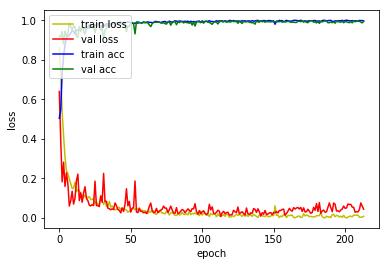

3183/3183 [==============================] - 3s 1ms/sample - loss: 10.0830 - acc: 0.3371
Loss: 10.082969008030192 Accuracy: 0.33710337



In [13]:
for i in range(3, 8):
    base = 'vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO'
    model_name = base+'_{}_conv'.format(i)
    
#     with tf.device('/cpu:1'):
    model = build_2d_cnn_custom_ch_32_DO(conv_num=i)
#     model = multi_gpu_model(model, gpus=2)    
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=100)
    hist = model.fit_generator(data_generator,
            steps_per_epoch=len(x_train)//batch_size,
            epochs=10000,
            validation_data=(x_val, y_val),
            callbacks = [checkpointer, early_stopping],
            workers=8, 
            use_multiprocessing=True
    )
    
    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test, y_test)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [16]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = 'vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 8):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_val, y_val)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 172, 172, 3)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 172, 172, 32)      2432      
_________________________________________________________________
activation_28 (Activation)   (None, 172, 172, 32)      0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 86, 86, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 86, 86, 32)        25632     
_________________________________________________________________
activation_29 (Activation)   (None, 86, 86, 32)        0         
________________________________________________________________

3183/3183 [==============================] - 4s 1ms/sample - loss: 10.5307 - acc: 0.3384
Loss: 10.530664003067498 Accuracy: 0.33836004

vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 172, 172, 3)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 172, 172, 32)      2432      
_________________________________________________________________
activation_46 (Activation)   (None, 172, 172, 32)      0         
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 86, 86, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 86, 86, 32)        25632     
_____________________________________________________________

In [15]:
for i in range(3, 8):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test, y_test)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 172, 172, 3)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 172, 172, 32)      2432      
_________________________________________________________________
activation_28 (Activation)   (None, 172, 172, 32)      0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 86, 86, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 86, 86, 32)        25632     
_________________________________________________________________
activation_29 (Activation)   (None, 86, 86, 32)        0         
________________________________________________________________

3183/3183 [==============================] - 4s 1ms/sample - loss: 10.5985 - acc: 0.3384
Loss: 10.598501925748865 Accuracy: 0.33836004

vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 172, 172, 3)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 172, 172, 32)      2432      
_________________________________________________________________
activation_46 (Activation)   (None, 172, 172, 32)      0         
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 86, 86, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 86, 86, 32)        25632     
_____________________________________________________________

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
i = 7
model_name = base+'_{}_conv'.format(i)
print()
print(model_name, 'Model')
model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
model_filename = model_path + sorted(os.listdir(model_path))[-1]

model = load_model(model_filename)
model.summary()

[loss, accuracy] = model.evaluate(x_val, y_val)
print('Loss:', loss, 'Accuracy:', accuracy)


vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_075_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 172, 172, 3)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 172, 172, 32)      2432      
_________________________________________________________________
activation_46 (Activation)   (None, 172, 172, 32)      0         
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 86, 86, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 86, 86, 32)        25632     
_________________________________________________________________
activation_47 (Activation)   (None, 86, 86, 32)        0         
________________________________________________________________

In [22]:
y_pred

array([0, 0, 0, ..., 0, 1, 1])

Confusion Matrix
[[  29    1    0    0    0    0]
 [   6 1044    0    0    0    0]
 [  14   64    0    0    0    0]
 [ 145 1795    0    0    0    0]
 [   8   26    0    0    0    0]
 [   1   50    0    0    0    0]]

Classification Report
              precision    recall  f1-score   support

           0       0.14      0.97      0.25        30
           1       0.35      0.99      0.52      1050
           2       0.00      0.00      0.00        78
           3       0.00      0.00      0.00      1940
           4       0.00      0.00      0.00        34
           5       0.00      0.00      0.00        51

   micro avg       0.34      0.34      0.34      3183
   macro avg       0.08      0.33      0.13      3183
weighted avg       0.12      0.34      0.17      3183




/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


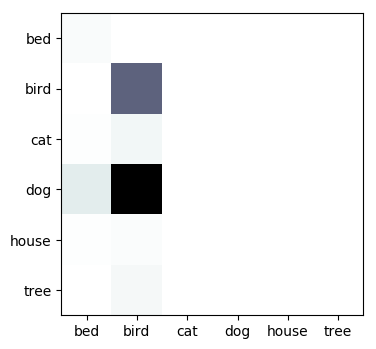

In [21]:
Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
y_real = np.argmax(y_test, axis=1)
confusion_mat = confusion_matrix(y_real, y_pred)
print('Confusion Matrix')
print(confusion_mat)
print()

print('Classification Report')
print(classification_report(y_real, y_pred))
print()

# labels = y_table.T[0]
plt.figure(figsize=(4,4), dpi=100)
plt.xticks(np.arange(len(y_list)), y_list)
plt.yticks(np.arange(len(y_list)), y_list)
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.bone_r)